# 🎶 Music Generation with Transformers

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the Model](#build)
3. [Train the Model](#train)
4. [Generate images](#generate)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

import os
import glob
import json
from pprint import pprint
import random
import re
import time

import string
from IPython.display import display, HTML

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
import keras_nlp

import music21

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from utils.music import parse_midi_files, create_lookup_tables, load_parsed_files, get_midi_note

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [2]:
PARSE_MIDI_FILES = False
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [3]:
# Load the data
file_list = glob.glob('/app/data/bach-cello/*.mid')
print(f'Found {len(file_list)} midi files')

Found 36 midi files


In [4]:
parser = music21.converter

In [5]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(file_list, parser, SEQ_LEN + 1)
else:
    notes, durations = load_parsed_files()

In [26]:
example_notes = notes[0]
example_durations = durations[0]

print("{:10} {:10}".format("pitch","duration"))
for n, d in zip(example_notes.split()[:11], example_durations.split()[:11]):
    print(f"{n:10} {d:10}")

pitch      duration  
START      0.0       
G:major    0.0       
4/4TS      0.0       
G2         0.25      
D3         0.25      
B3         0.25      
A3         0.25      
B3         0.25      
D3         0.25      
B3         0.25      
D3         0.25      


## 2. Tokenize the data <a name="tokenize"></a>

In [7]:
def create_dataset(elements):
    ds = tf.data.Dataset.from_tensor_slices(elements).batch(BATCH_SIZE, drop_remainder = True).shuffle(1000)
    vectorize_layer = keras.layers.TextVectorization(standardize = None, output_mode="int")
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab

notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(durations)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))


In [30]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("pitch token","duration token"))
for i, (note_int, duration_int) in enumerate(zip(example_tokenised_notes.numpy()[:11], example_tokenised_durations.numpy()[:11])):
    print(f'{note_int:10}{duration_int:10}')

pitch token duration token
        37        10
        51        10
        42        10
        16         2
         4         2
         9         2
         3         2
         9         2
         4         2
         9         2
         4         2


In [9]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f'{i}: {note}')

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f'{i}: {note}')


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 1/6


## 3. Create the Training Set <a name="create"></a>

In [11]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1],  tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y

ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [12]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 9,  6,  7, ...,  7,  9,  6],
       [ 6,  7, 15, ...,  9,  6,  3],
       [ 7, 15,  6, ...,  6,  3,  3],
       ...,
       [ 6,  9,  3, ...,  7,  6, 12],
       [ 9,  3,  9, ...,  6, 12,  6],
       [ 3,  9,  3, ..., 12,  6, 18]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[8, 2, 2, ..., 3, 3, 4],
       [2, 2, 2, ..., 3, 4, 3],
       [2, 2, 2, ..., 4, 3, 3],
       ...,
       [4, 4, 4, ..., 4, 4, 2],
       [4, 4, 2, ..., 4, 2, 2],
       [4, 2, 2, ..., 2, 2, 3]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 6,  7, 15, ...,  9,  6,  3],
       [ 7, 15,  6, ...,  6,  3,  3],
       [15,  6,  6, ...,  3,  3, 13],
       ...,
       [ 9,  3,  9, ...,  6, 12,  6],
       [ 3,  9,  3, ..., 12,  6, 18],
       [ 9,  3,  2, ...,  6, 18,  7]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 3, 4, 3],
       [2, 2, 2, ..., 4, 3, 3],
       [2, 2, 3, ..., 3, 3, 4],
       ...,

## 5. Create the causal attention mask function <a name="causal"></a>

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

np.transpose(causal_attention_mask(1, 10,10,dtype = tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [ ]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, name, dropout_rate = DROPOUT_RATE):
        super(TransformerBlock, self).__init__(name = name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = keras.layers.MultiHeadAttention(num_heads, key_dim, output_shape = embed_dim)
        self.dropout_1 = keras.layers.Dropout(self.dropout_rate)
        self.ln_1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = keras.layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = keras.layers.Dense(self.embed_dim)
        self.dropout_2 = keras.layers.Dropout(self.dropout_rate)
        self.ln_2 = keras.layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output, attention_scores = self.attn(inputs, inputs, attention_mask=causal_mask, return_attention_scores=True)
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "key_dim": self.key_dim,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [57]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, embeddings_initializer = 'he_uniform')
        self.pos_emb = keras_nlp.layers.SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

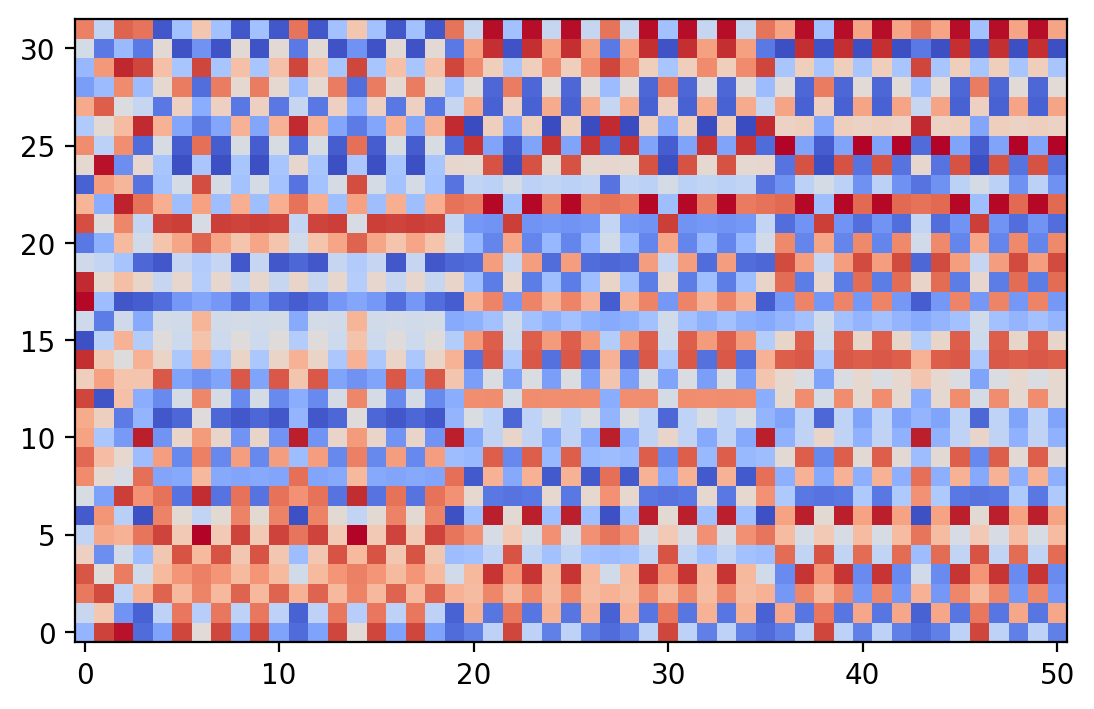

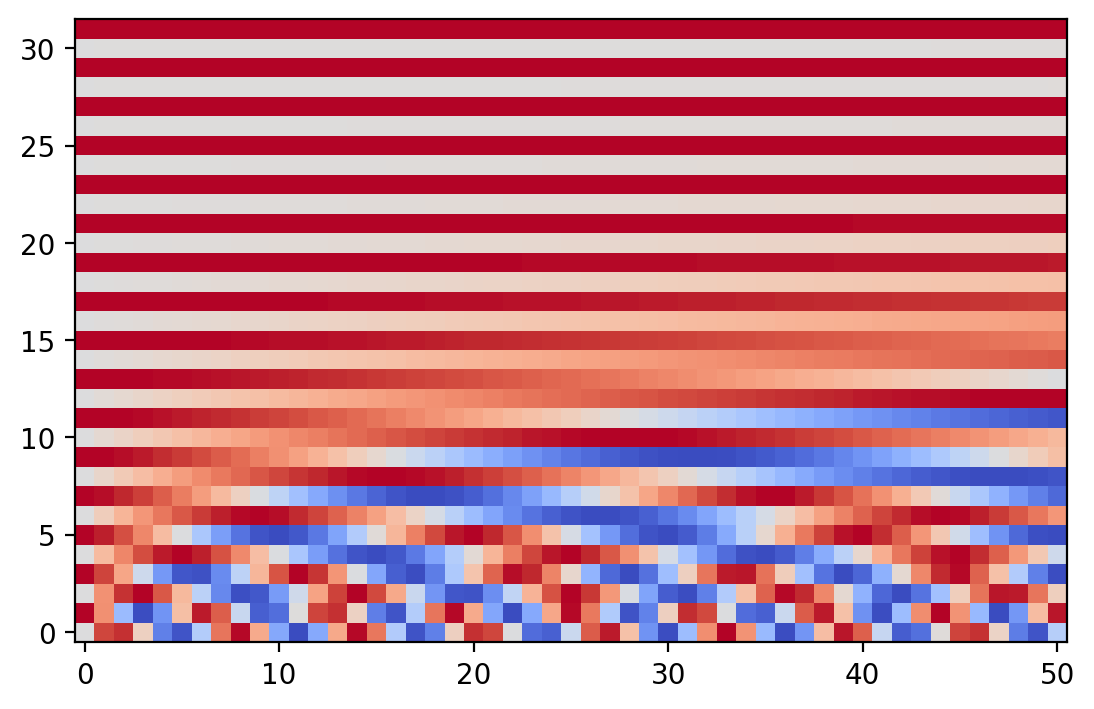

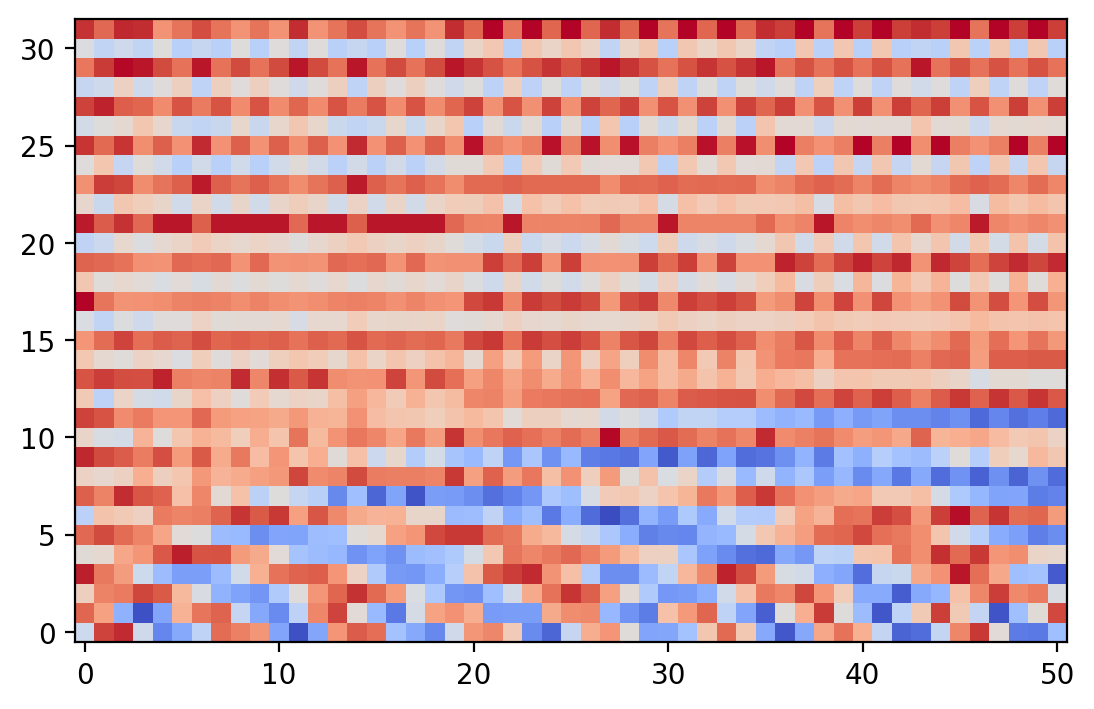

In [58]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(np.transpose(token_embedding), cmap='coolwarm', interpolation='nearest', origin = 'lower')
plt.show()
plt.imshow(np.transpose(position_embedding), cmap='coolwarm', interpolation='nearest', origin = 'lower')
plt.show()
plt.imshow(np.transpose(embedding), cmap='coolwarm', interpolation='nearest', origin = 'lower')
plt.show()


## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [76]:
note_inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(notes_vocab_size, EMBEDDING_DIM // 2)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(durations_vocab_size, EMBEDDING_DIM // 2)(durations_inputs)
embeddings = keras.layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name = 'attention')(embeddings)
note_outputs = keras.layers.Dense(notes_vocab_size, activation = 'softmax', name = 'note_outputs' )(x)
duration_outputs = keras.layers.Dense(durations_vocab_size, activation = 'softmax' , name = 'duration_outputs')(x)
model = keras.Model(
    inputs=[note_inputs, durations_inputs]
    , outputs=[note_outputs, duration_outputs] #attention_scores
)
model.compile("adam"
              , loss=[keras.losses.SparseCategoricalCrossentropy(), keras.losses.SparseCategoricalCrossentropy()]
             )
att_model = keras.Model(
    inputs=[note_inputs, durations_inputs]
    , outputs=attention_scores
)

In [77]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, None, 128)   7552        ['input_3[0][0]']                
 8 (TokenAndPositionEmbedding)                                                                    
                                                                                                  
 token_and_position_embedding_1  (None, None, 128)   3072        ['input_4[0][0]']            

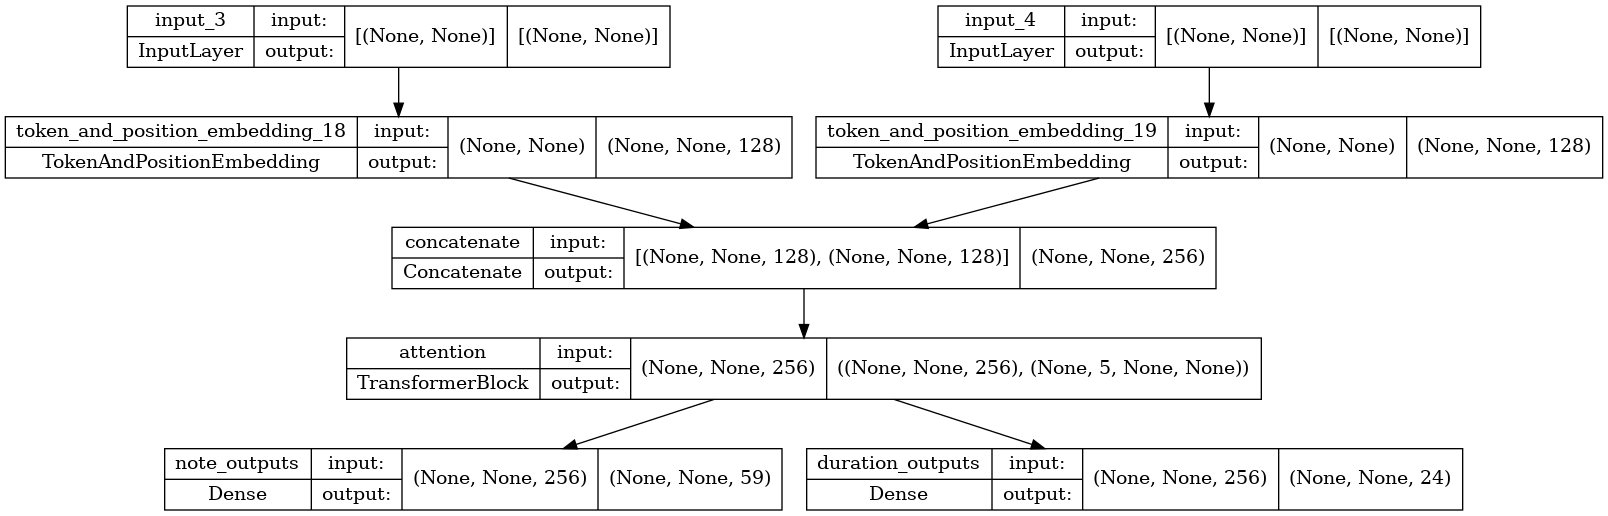

In [78]:
plot_model(model
           , show_shapes=True
           , show_layer_names=True
        )

In [79]:
if LOAD_MODEL:
    model.load_weights('./checkpoint/checkpoint.ckpt')
    # model = keras.models.load_model('./models/model', compile=True)

ValueError: Shapes (59, 128) and (473, 256) are incompatible

## 9. Train the Transformer <a name="train"></a>

In [215]:
# Create a MusicGenerator checkpoint
class MusicGenerator(keras.callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {note: index for index, note in enumerate(index_to_note)}
        self.index_to_duration = index_to_duration
        self.duration_to_index = {duration: index for index, duration in enumerate(index_to_duration)}
        
    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs 
    
    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(notes[0][-1], temperature)
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(durations[0][-1], temperature)
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)
        
        return new_note, sample_note_idx, sample_note, note_probs, sample_duration_idx, sample_duration, duration_probs
    
    
    def generate(self, start_notes, start_durations, max_tokens, temperature):
        
        attention_model = keras.Model(inputs=self.model.input, outputs=self.model.get_layer('attention').output)
        
        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [self.duration_to_index.get(x, 1) for x in start_durations]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()
        
        midi_stream.append(music21.clef.BassClef())
        
        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)
            
        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1,x2], verbose = 0)
            
            repeat = True
            
            while repeat:
            
                new_note \
                , sample_note_idx \
                , sample_note \
                , note_probs \
                , sample_duration_idx \
                , sample_duration \
                , duration_probs = self.get_note(notes, durations, temperature)

                if (isinstance(new_note, music21.chord.Chord) \
                    or isinstance(new_note, music21.note.Note) \
                    or isinstance(new_note, music21.note.Rest)) \
                    and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False
            
            if new_note is not None:
                midi_stream.append(new_note)
                
            _, att = attention_model.predict([x1,x2], verbose = 0)

            info.append({
                'prompt': [start_notes.copy(), start_durations.copy()] 
                , 'midi': midi_stream
                , 'note_probs': note_probs
                , 'duration_probs': duration_probs
                , 'atts': att[0,:,-1,:]
            })
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)
            
            if sample_note == 'START':
                break
        
        return info
        
    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(["START"], ["0.0"], max_tokens = GENERATE_LEN, temperature = 0.5)
        midi_stream = info[-1]['midi'].chordify()
        print(info[-1]['prompt'])
        midi_stream.show()
        midi_stream.write("midi", fp=os.path.join('/app/notebooks/music/bach-cello/output', "output-" + str(epoch).zfill(4) + ".mid"))
        

In [216]:
# Create a model save checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

Epoch 1/5000
  6/108 [>.............................] - ETA: 6s - loss: 6.9035 - note_outputs_loss: 4.0058 - duration_outputs_loss: 2.8977WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0320s vs `on_train_batch_end` time: 0.0382s). Check your callbacks.


108/108 [==============================] - ETA: 0s - loss: 5.1075 - note_outputs_loss: 3.4835 - duration_outputs_loss: 1.6241[['START', 'G#3', 'F3', 'C4', 'G3', 'G3', 'G3', 'A3', 'A3', 'G3', 'F3', 'A3', 'F3', 'F3', 'D3', 'A3', 'G3', 'G3', 'G3', 'D3', 'E-3', 'E3', 'B2', 'A3', 'G3', 'G3', 'G3', 'G3', 'D3', 'E4', 'G3', 'F3', 'A3', 'F3', 'B3', 'D3', 'G3', 'F3', 'D4', 'E3', 'A3', 'G3', 'G#3', 'G3', 'C3', 'G3', 'G3', 'F3', 'G3'], ['0.0', '0.25', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.5', '0.25']]


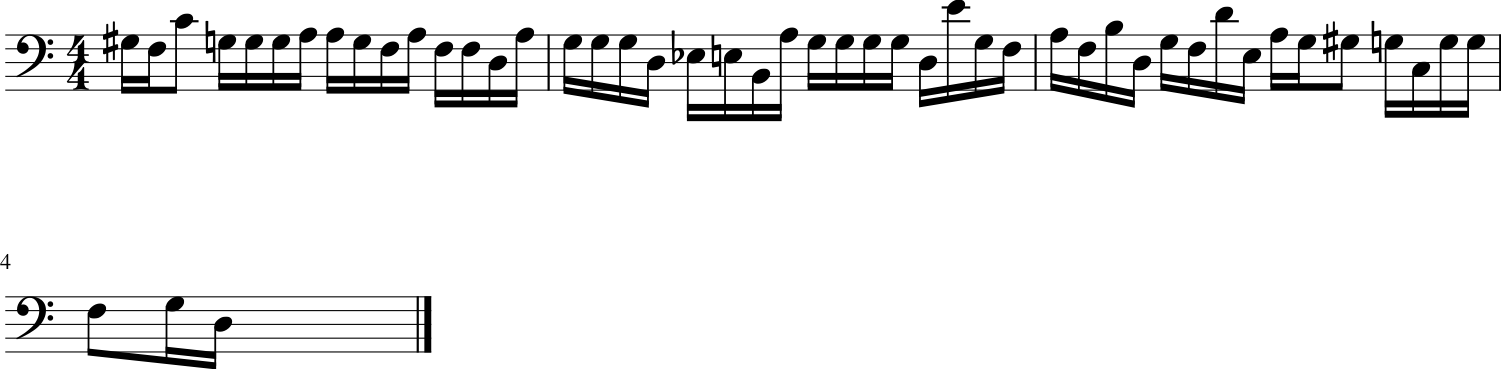

108/108 [==============================] - 15s 125ms/step - loss: 5.1075 - note_outputs_loss: 3.4835 - duration_outputs_loss: 1.6241
Epoch 2/5000
108/108 [==============================] - ETA: 0s - loss: 4.5753 - note_outputs_loss: 3.3615 - duration_outputs_loss: 1.2138[['START', 'A3', 'F3', 'C4', 'C3', 'G#3', 'C3', 'E4', 'G3', 'E4', 'B2', 'E-3', 'E-3', 'C4', 'C4', 'F#3', 'C#4', 'D4', 'E4', 'F#3', 'C4', 'E-3', 'C4', 'F3', 'D3', 'C3', 'C3', 'C4', 'C4', 'D4', 'F3', 'D4', 'D3', 'C3', 'A3', 'E4', 'C3', 'F3', 'A3', 'E-3', 'A3', 'C3', 'D4', 'D4', 'B3', 'E-3', 'A3', 'B3', 'F3'], ['0.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


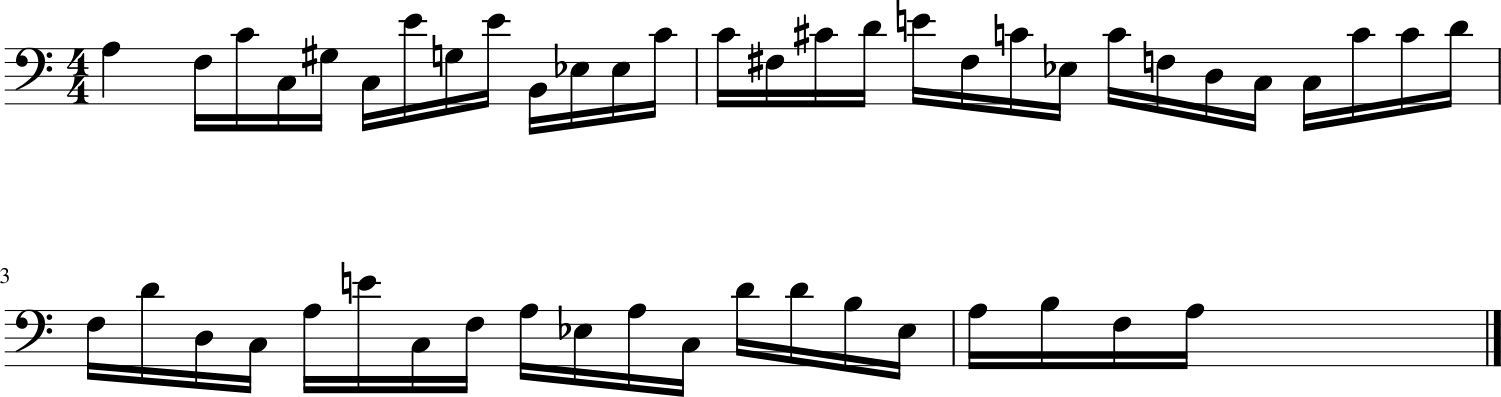

108/108 [==============================] - 13s 117ms/step - loss: 4.5753 - note_outputs_loss: 3.3615 - duration_outputs_loss: 1.2138
Epoch 3/5000
108/108 [==============================] - ETA: 0s - loss: 4.1316 - note_outputs_loss: 3.2559 - duration_outputs_loss: 0.8757[['START', 'G3', 'G3', 'C4', 'C4', 'C4', 'D4', 'C4', 'C4', 'G3', 'D4', 'G3', 'F#3', 'G2', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'C3', 'D3', 'C3', 'D3', 'D3', 'D3', 'C3', 'D3', 'D3', 'C3', 'D3', 'C3', 'D3', 'E3', 'D3', 'E-3', 'D3', 'D3', 'C3', 'G2', 'D3', 'D3', 'D3', 'C3', 'D3', 'B2', 'D3', 'C3', 'D3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


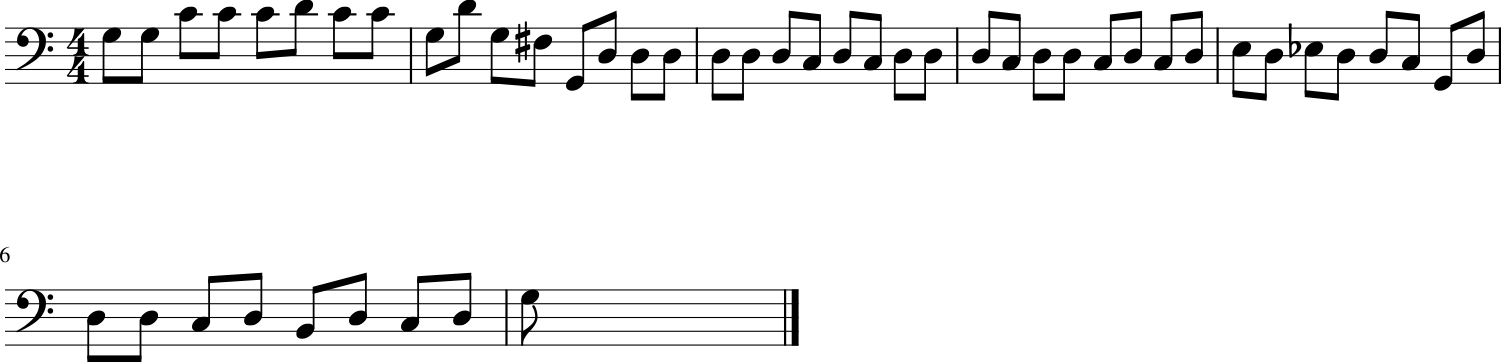

108/108 [==============================] - 15s 143ms/step - loss: 4.1316 - note_outputs_loss: 3.2559 - duration_outputs_loss: 0.8757
Epoch 4/5000
108/108 [==============================] - ETA: 0s - loss: 3.7838 - note_outputs_loss: 2.9817 - duration_outputs_loss: 0.8022[['START', 'A3', 'E3', 'D3', 'E3', 'D3', 'D3', 'D3', 'D3', 'E3', 'D3', 'E3', 'D3', 'E3', 'D3', 'D3', 'G3', 'F3', 'D3', 'E3', 'F#3', 'E3', 'E3', 'D3', 'E3', 'D3', 'D3', 'E3', 'D3', 'D3', 'D3', 'E3', 'D3', 'D3', 'E3', 'D3', 'D3', 'E3', 'E-3', 'D3', 'E3', 'F#3', 'A3', 'G3', 'D3', 'E3', 'G3', 'D3', 'E3'], ['0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


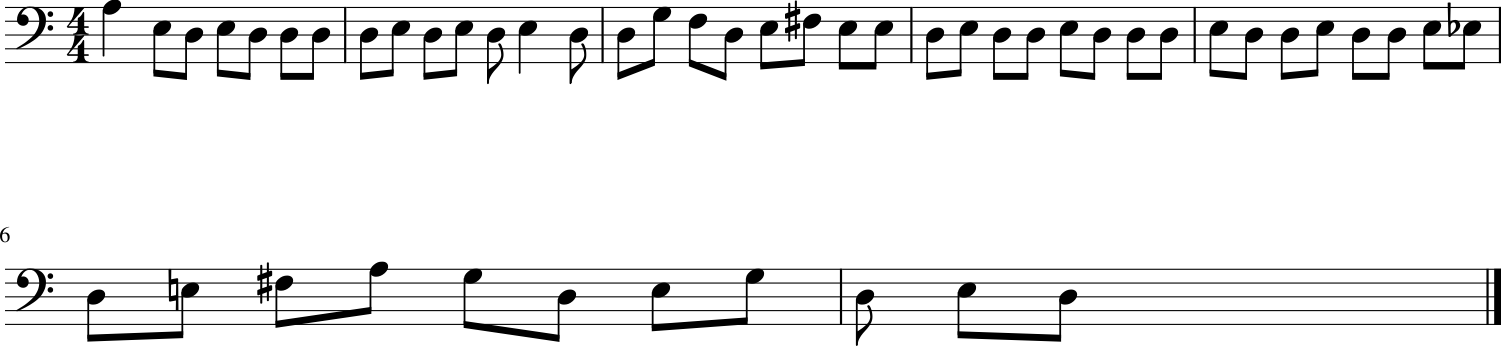

108/108 [==============================] - 13s 117ms/step - loss: 3.7838 - note_outputs_loss: 2.9817 - duration_outputs_loss: 0.8022
Epoch 5/5000
108/108 [==============================] - ETA: 0s - loss: 3.5847 - note_outputs_loss: 2.8070 - duration_outputs_loss: 0.7776[['START', 'A4', 'G4', 'F#4', 'F#4', 'D4', 'D4', 'C#4', 'A3', 'F3', 'E3', 'D3', 'B2', 'E3', 'C3', 'A3', 'B3', 'E3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'A3', 'G3', 'F3', 'G3', 'F3', 'D3', 'G3', 'F3', 'G3', 'F3', 'E3', 'A3', 'B-3', 'G3', 'F3', 'E-3', 'D3', 'D3', 'E3', 'F3', 'C3', 'D3', 'E-3', 'F3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


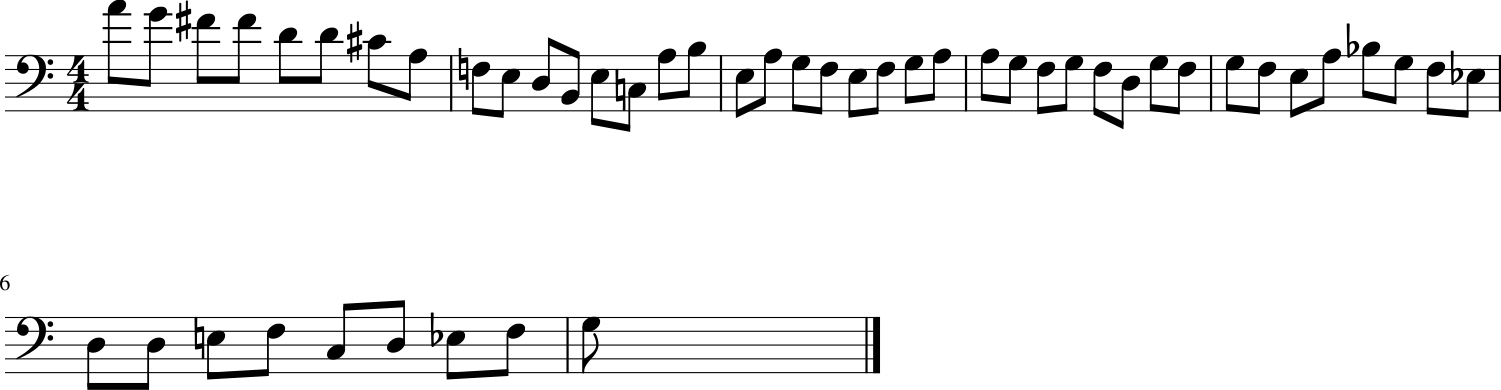

108/108 [==============================] - 14s 129ms/step - loss: 3.5847 - note_outputs_loss: 2.8070 - duration_outputs_loss: 0.7776
Epoch 6/5000
108/108 [==============================] - ETA: 0s - loss: 3.4607 - note_outputs_loss: 2.7156 - duration_outputs_loss: 0.7451[['START', 'A4', 'A4', 'A4', 'E4', 'D4', 'C#4', 'D4', 'D4', 'E4', 'D4', 'F#4', 'D4', 'D4', 'E4', 'E4', 'E4', 'E4', 'D4', 'A3', 'A3', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'A3', 'A3', 'A3', 'A3', 'B3', 'C#4', 'D4', 'B3', 'A3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'E3', 'F#3', 'A3', 'B3', 'A3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


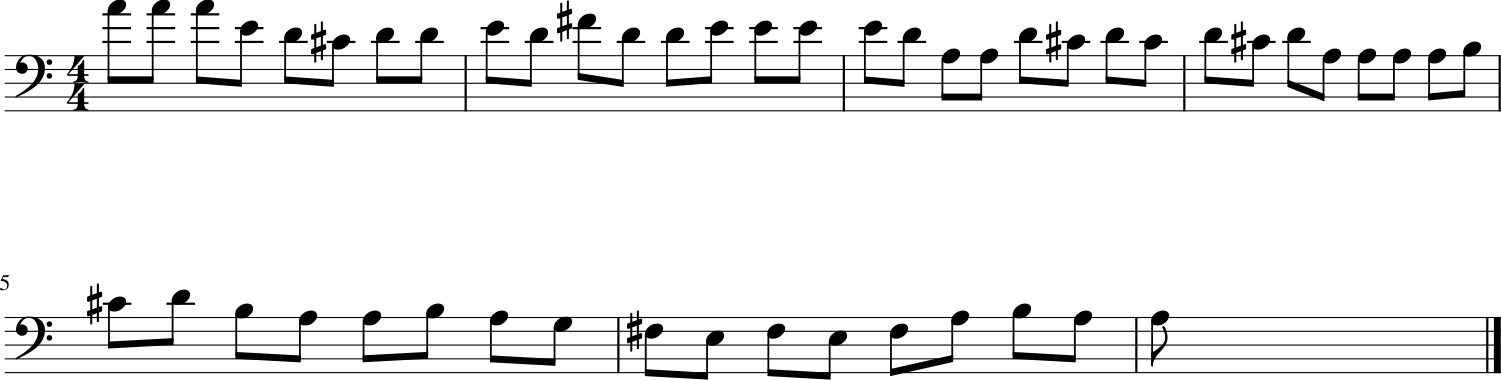

108/108 [==============================] - 13s 120ms/step - loss: 3.4607 - note_outputs_loss: 2.7156 - duration_outputs_loss: 0.7451
Epoch 7/5000
108/108 [==============================] - ETA: 0s - loss: 3.3433 - note_outputs_loss: 2.6339 - duration_outputs_loss: 0.7095[['START', 'A4', 'B4', 'G4', 'F#3', 'A3', 'B3', 'F#3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'A3', 'G3', 'F3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B-3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B-3', 'A3', 'B3', 'C4', 'B3'], ['0.0', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3']]


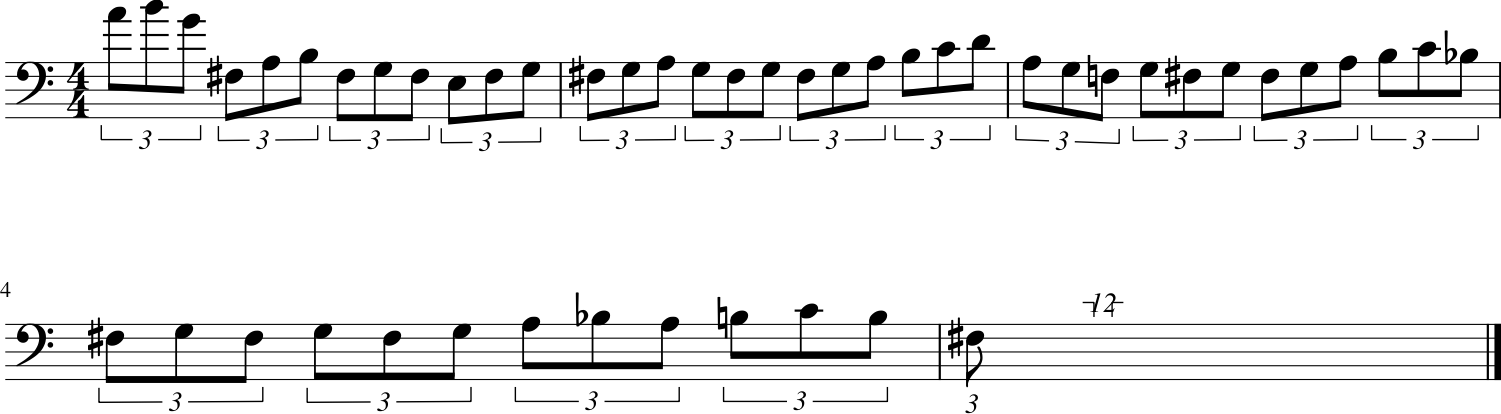

108/108 [==============================] - 14s 128ms/step - loss: 3.3433 - note_outputs_loss: 2.6339 - duration_outputs_loss: 0.7095
Epoch 8/5000
108/108 [==============================] - ETA: 0s - loss: 3.2856 - note_outputs_loss: 2.6141 - duration_outputs_loss: 0.6716[['START', 'B4', 'B4', 'A4', 'A4', 'G4', 'A4', 'A4', 'A4', 'F#4', 'F#4', 'G#4', 'A4', 'B4', 'A4', 'F#4', 'F#4', 'E4', 'F#4', 'F#4', 'G4', 'G4', 'G#4', 'A4', 'B4', 'A4', 'A4', 'B4', 'A4', 'A4', 'A4', 'G4', 'A4', 'A4', 'B4', 'A4', 'B4', 'F#4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'B4', 'A4', 'A4', 'A4'], ['0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


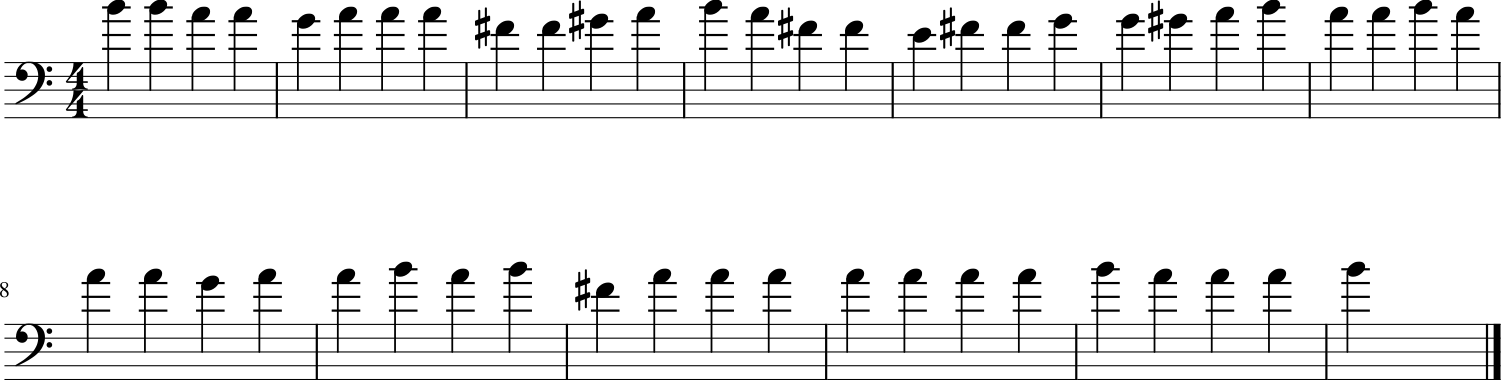

108/108 [==============================] - 13s 118ms/step - loss: 3.2856 - note_outputs_loss: 2.6141 - duration_outputs_loss: 0.6716
Epoch 9/5000
108/108 [==============================] - ETA: 0s - loss: 3.2061 - note_outputs_loss: 2.5567 - duration_outputs_loss: 0.6494[['START', 'A4', 'A4', 'A4', 'F#4', 'G4', 'E4', 'C#4', 'B3', 'E4', 'G4', 'E4', 'D4', 'C#4', 'D4', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C#4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C#4', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'D4', 'B3', 'A3', 'D4', 'B3', 'C#4'], ['0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


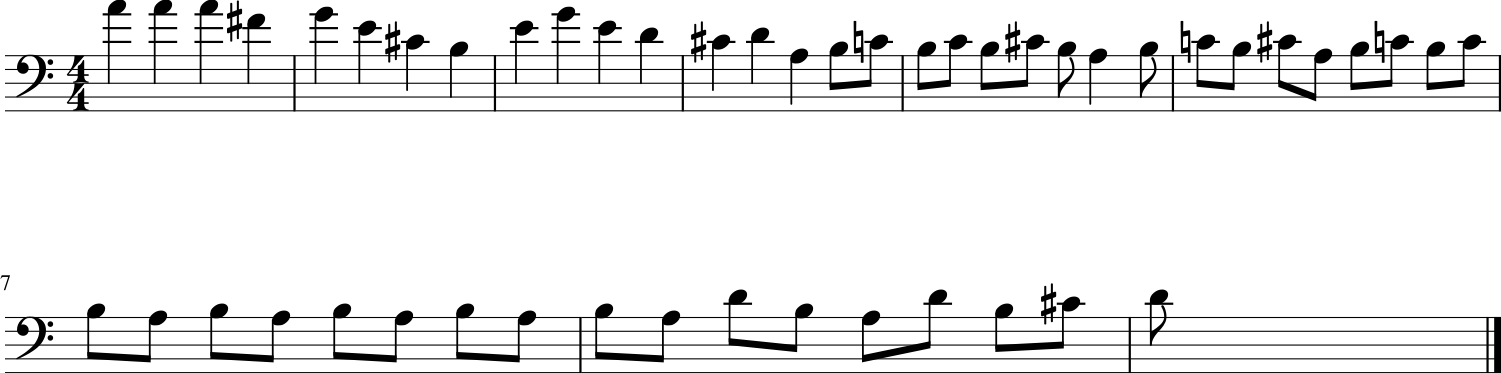

108/108 [==============================] - 13s 118ms/step - loss: 3.2061 - note_outputs_loss: 2.5567 - duration_outputs_loss: 0.6494
Epoch 10/5000
108/108 [==============================] - ETA: 0s - loss: 3.1544 - note_outputs_loss: 2.5179 - duration_outputs_loss: 0.6365[['START', 'A4', 'A4', 'G4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'C#4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'F#4', 'F#4', 'E4', 'E4', 'D4', 'E4', 'E4', 'E4', 'F#4', 'F#4', 'F#4', 'E4', 'F#4', 'E4', 'E4', 'D4', 'C#4', 'A3', 'B3', 'C#4', 'A3', 'D4', 'E4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'E4', 'F#4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


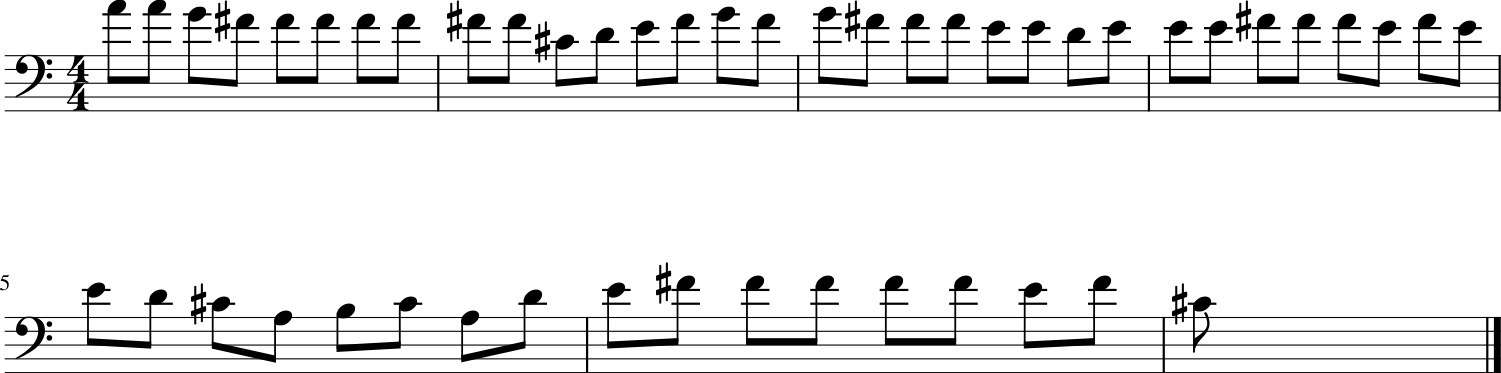

108/108 [==============================] - 13s 118ms/step - loss: 3.1544 - note_outputs_loss: 2.5179 - duration_outputs_loss: 0.6365
Epoch 11/5000
108/108 [==============================] - ETA: 0s - loss: 3.1128 - note_outputs_loss: 2.4987 - duration_outputs_loss: 0.6141[['START', '3/4TS', 'A4', 'G4', 'G4', 'F#4', 'F#4', 'F#4', 'G4', 'E4', 'G4', 'F#4', 'E4', 'D4', 'E4', 'E4', 'F#4', 'E4', 'F#4', 'D4', 'C#4', 'D4', 'E4', 'E4', 'E4', 'E4', 'F#4', 'F#4', 'E4', 'F#4', 'E4', 'F#4', 'F#4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'E4', 'A3', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'D4'], ['0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


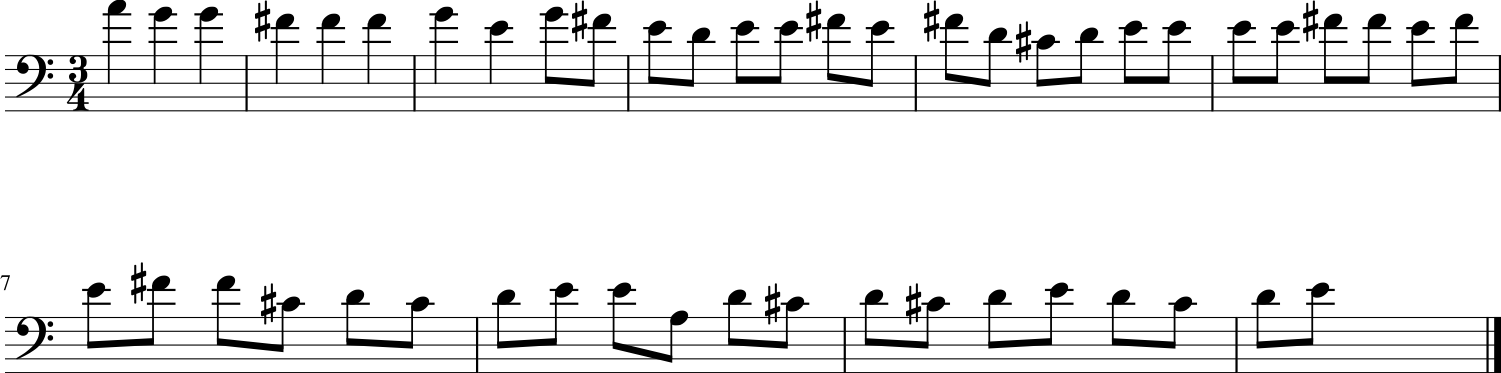

108/108 [==============================] - 13s 118ms/step - loss: 3.1128 - note_outputs_loss: 2.4987 - duration_outputs_loss: 0.6141
Epoch 12/5000
108/108 [==============================] - ETA: 0s - loss: 3.0634 - note_outputs_loss: 2.4663 - duration_outputs_loss: 0.5971[['START', 'F:major', '4/4TS', 'rest', 'E3', 'G2', 'A3', 'B3', 'A3', 'F#3', 'E3', 'D3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'D3', 'E3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'G#3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


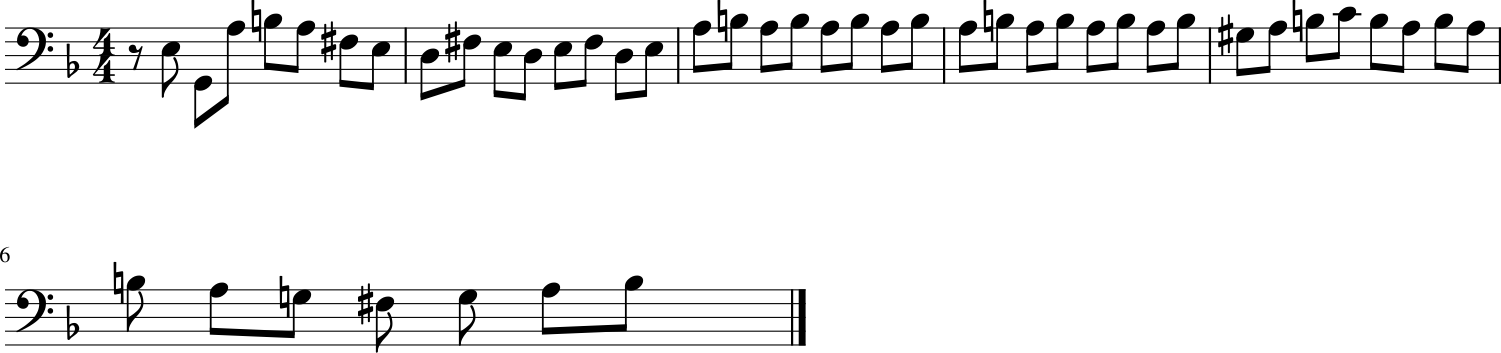

108/108 [==============================] - 13s 122ms/step - loss: 3.0634 - note_outputs_loss: 2.4663 - duration_outputs_loss: 0.5971
Epoch 13/5000
108/108 [==============================] - ETA: 0s - loss: 3.0432 - note_outputs_loss: 2.4548 - duration_outputs_loss: 0.5884[['START', 'E-:major', 'F:major', 'F2', 'E2', 'G2', 'F2', 'G2', 'F2', 'E2', 'F2', 'G2', 'F2', 'E-2', 'F2', 'C4', 'B-3', 'B-3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'E-3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


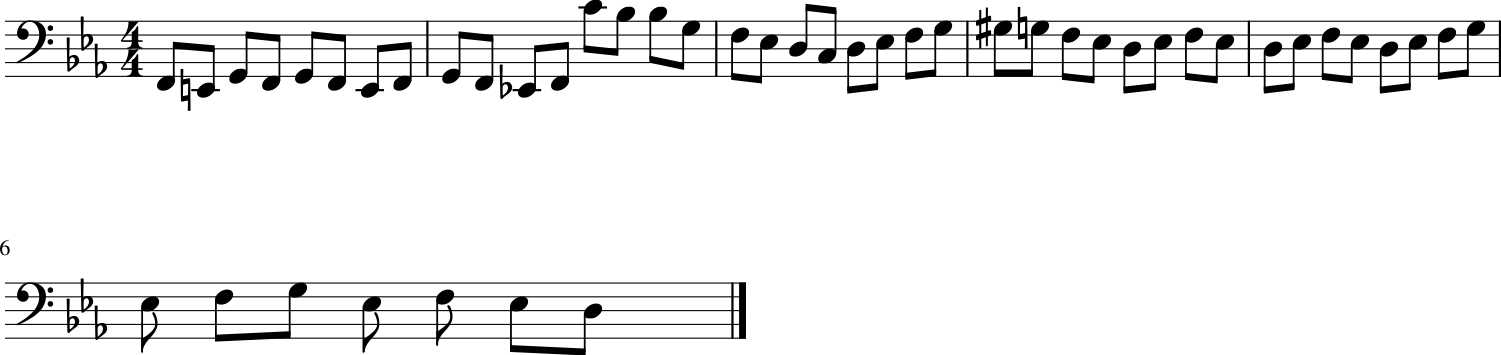

108/108 [==============================] - 13s 118ms/step - loss: 3.0432 - note_outputs_loss: 2.4548 - duration_outputs_loss: 0.5884
Epoch 14/5000
108/108 [==============================] - ETA: 0s - loss: 3.0391 - note_outputs_loss: 2.4399 - duration_outputs_loss: 0.5992[['START', 'G:major', 'rest', 'rest', 'B3', 'D3', 'E3', 'F#3', 'E3', 'D3', 'D3', 'E3', 'F#3', 'D3', 'E3', 'F#3', 'E3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'D4', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'A3', 'A3', 'B3', 'A3'], ['0.0', '0.0', '0.5', '0.5', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


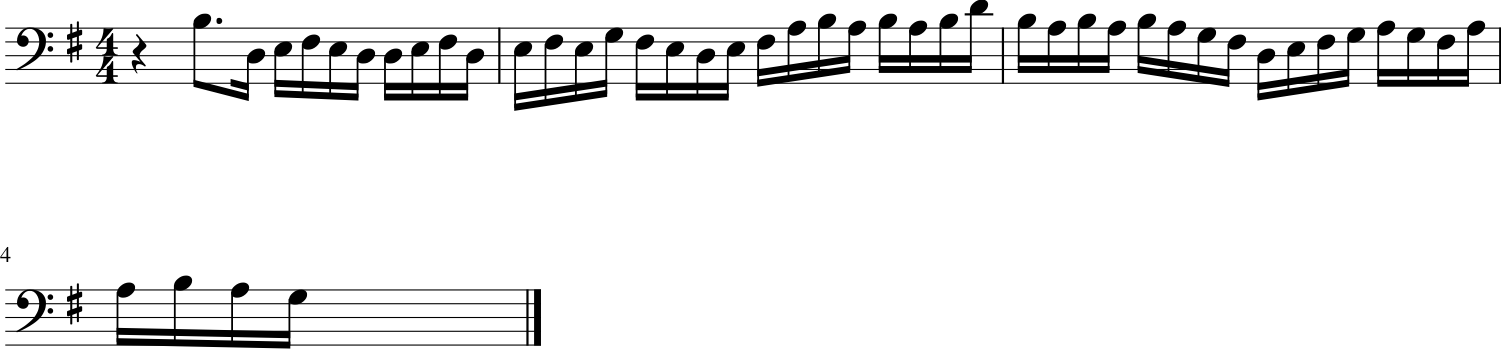

108/108 [==============================] - 13s 117ms/step - loss: 3.0391 - note_outputs_loss: 2.4399 - duration_outputs_loss: 0.5992
Epoch 15/5000
108/108 [==============================] - ETA: 0s - loss: 3.0168 - note_outputs_loss: 2.4297 - duration_outputs_loss: 0.5871[['START', 'B4', 'B4', 'A4', 'A4', 'A4', 'F#4', 'E4', 'E4', 'E4', 'F#4', 'E4', 'E4', 'E4', 'E4', 'F#4', 'E4', 'E4', 'E4', 'E4', 'F#4', 'E4', 'E4', 'E4', 'E4', 'F#4', 'E4', 'F#4', 'E4', 'E4', 'E4', 'F#4', 'E4', 'F#4', 'B4', 'B4', 'G#4', 'A4', 'B4', 'A4', 'B4', 'A4', 'F#4', 'F#4', 'E4', 'F#4', 'F#4', 'E4', 'F#4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


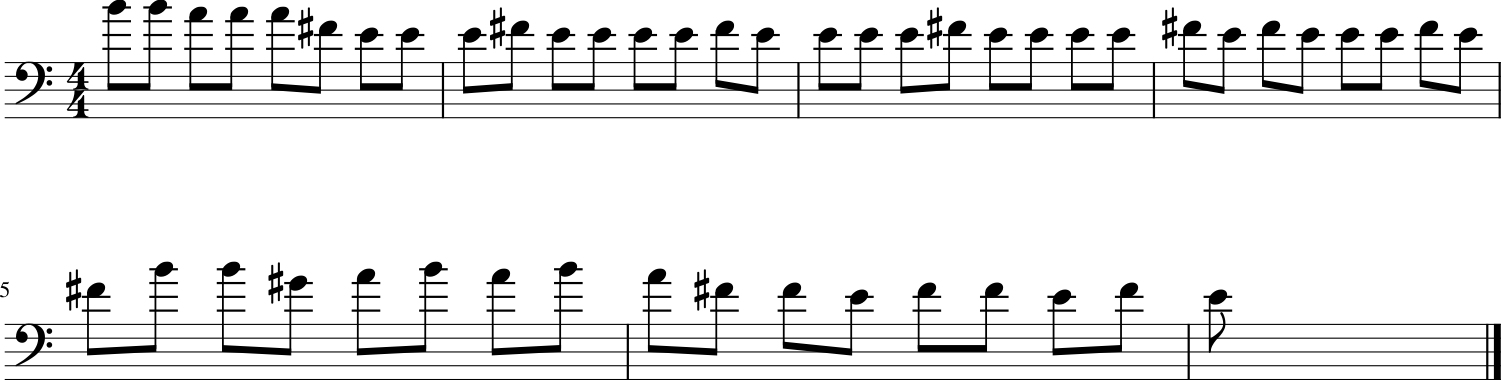

108/108 [==============================] - 14s 128ms/step - loss: 3.0168 - note_outputs_loss: 2.4297 - duration_outputs_loss: 0.5871
Epoch 16/5000
108/108 [==============================] - ETA: 0s - loss: 2.9849 - note_outputs_loss: 2.4166 - duration_outputs_loss: 0.5682[['START', 'F:major', 'E-:major', 'F:major', 'B-3', 'A3', 'B-3', 'A3', 'B-3', 'G3', 'B-3', 'C4', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'E-3', 'F3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'E-3', 'D3', 'F3'], ['0.0', '0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


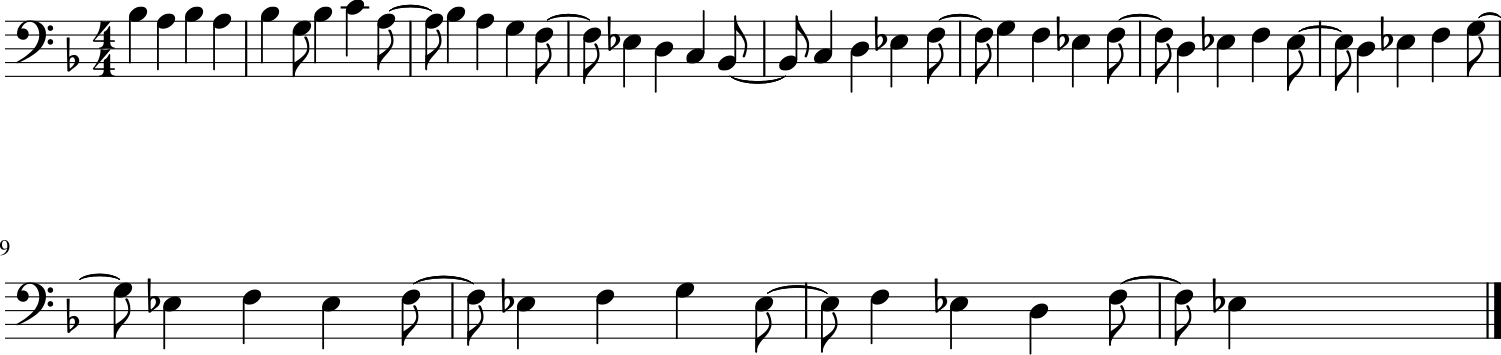

108/108 [==============================] - 16s 144ms/step - loss: 2.9849 - note_outputs_loss: 2.4166 - duration_outputs_loss: 0.5682
Epoch 17/5000
108/108 [==============================] - ETA: 0s - loss: 2.9851 - note_outputs_loss: 2.4080 - duration_outputs_loss: 0.5771[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'B-3', 'B-3', 'G#3', 'G3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'G#2', 'G2', 'G#2', 'B2', 'C3', 'G2', 'B-2', 'G#2', 'G2', 'G#2', 'B-2', 'G#2', 'B-2', 'G#2', 'G2', 'G#2', 'G2', 'D3', 'E-3', 'F3', 'G#2', 'G2', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'B-2', 'G#2', 'C3', 'G#2', 'C3', 'D3', 'E-3', 'F3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


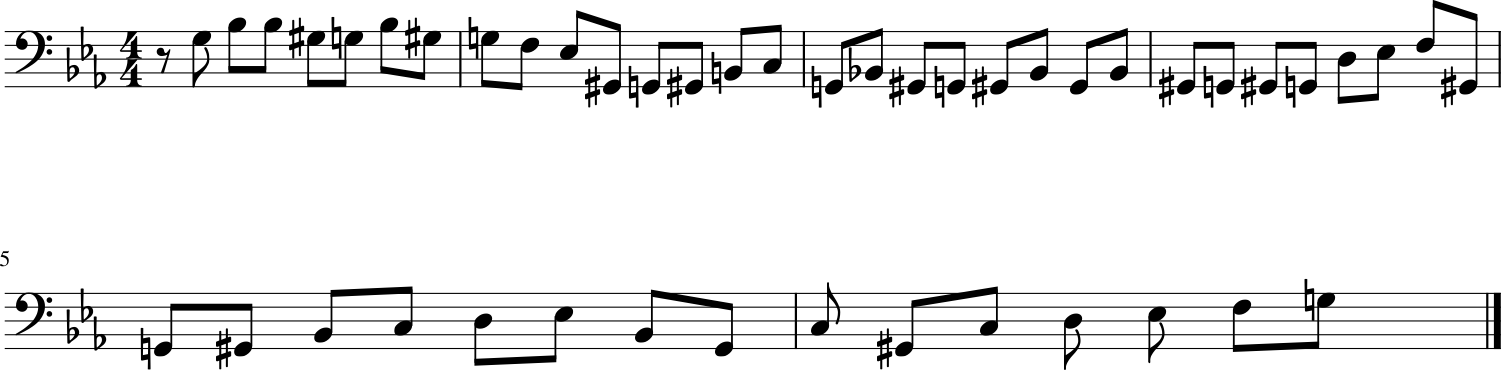

108/108 [==============================] - 13s 120ms/step - loss: 2.9851 - note_outputs_loss: 2.4080 - duration_outputs_loss: 0.5771
Epoch 18/5000
108/108 [==============================] - ETA: 0s - loss: 2.9668 - note_outputs_loss: 2.3939 - duration_outputs_loss: 0.5730[['START', '3/4TS', 'rest', 'B3', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'B3', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'G4', 'A4', 'E4', 'D4', 'C#4', 'D4', 'B3', 'C#4', 'D4', 'C#4', 'B3', 'A3', 'B3', 'C#4', 'D4', 'E4'], ['0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


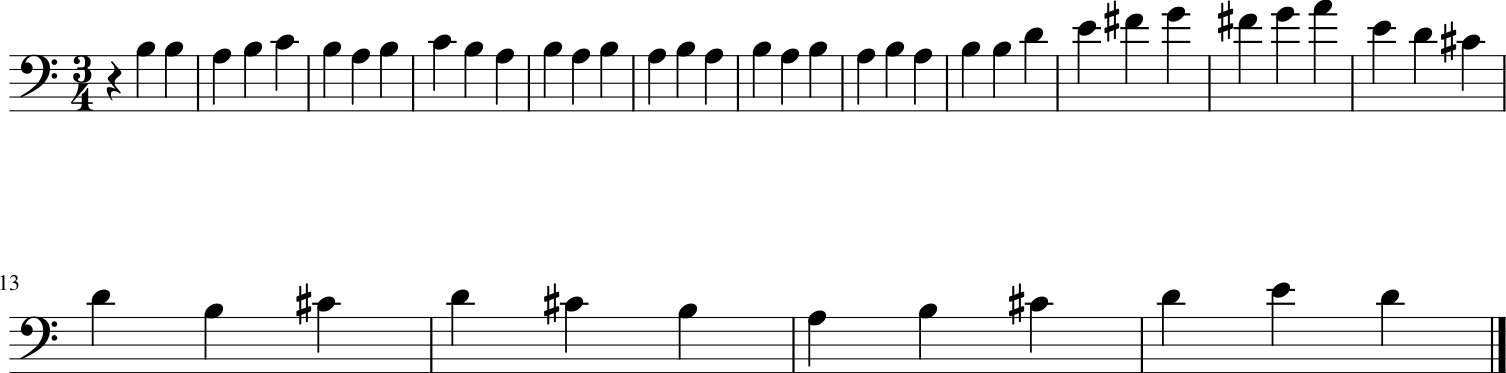

108/108 [==============================] - 13s 119ms/step - loss: 2.9668 - note_outputs_loss: 2.3939 - duration_outputs_loss: 0.5730
Epoch 19/5000
108/108 [==============================] - ETA: 0s - loss: 2.9438 - note_outputs_loss: 2.3796 - duration_outputs_loss: 0.5643[['START', 'E-:major', '3/8TS'], ['0.0', '0.0', '0.0']]


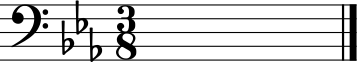

108/108 [==============================] - 8s 76ms/step - loss: 2.9438 - note_outputs_loss: 2.3796 - duration_outputs_loss: 0.5643
Epoch 20/5000
108/108 [==============================] - ETA: 0s - loss: 2.9451 - note_outputs_loss: 2.3844 - duration_outputs_loss: 0.5607[['START', '3/4TS', 'rest', 'rest', 'rest', 'rest', 'F#2', 'rest', 'D4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'F#4', 'D4', 'C#4', 'B3', 'C#4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'C#4', 'F#4', 'D4', 'E4', 'E4', 'F#4', 'E4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'D4', 'C#4', 'E4', 'F#4', 'C#4', 'F#4', 'F#4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


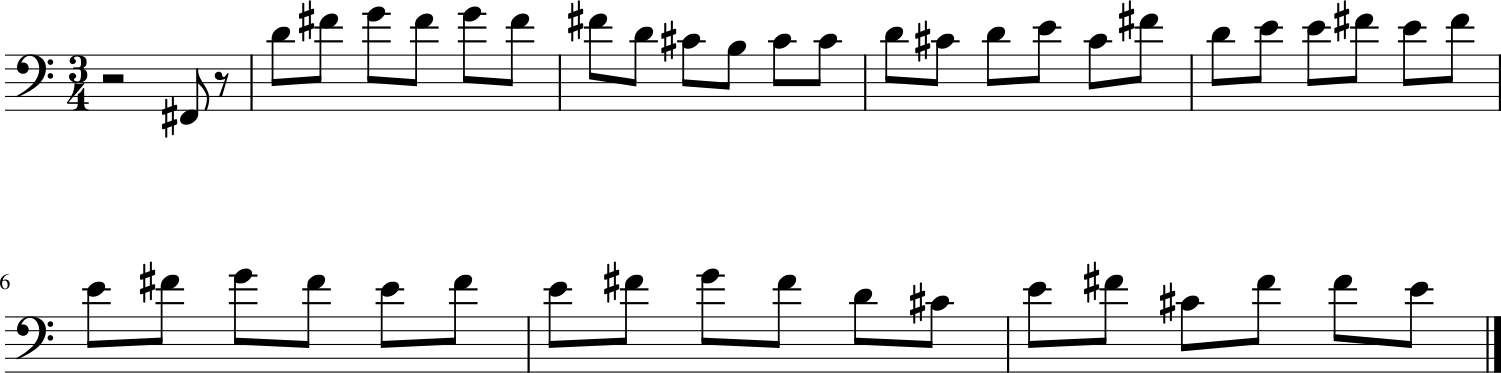

108/108 [==============================] - 13s 117ms/step - loss: 2.9451 - note_outputs_loss: 2.3844 - duration_outputs_loss: 0.5607
Epoch 21/5000
108/108 [==============================] - ETA: 0s - loss: 2.9244 - note_outputs_loss: 2.3588 - duration_outputs_loss: 0.5656[['START', 'G:major', 'F2', 'G2', 'B2', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'E3', 'D3', 'D3', 'C3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'C3', 'D3', 'E3', 'F3', 'D3', 'E3', 'C3', 'G2', 'F#2', 'A2', 'G3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'E3'], ['0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


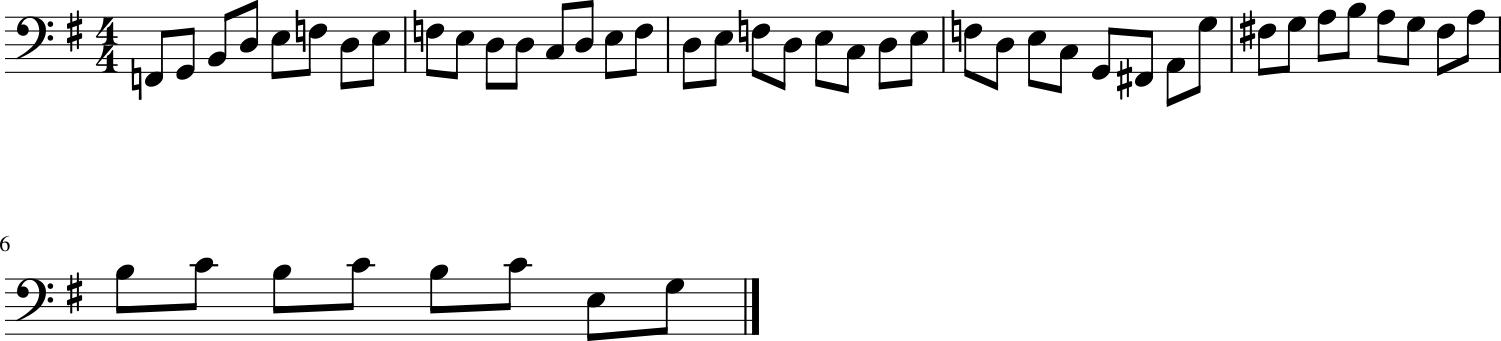

108/108 [==============================] - 15s 135ms/step - loss: 2.9244 - note_outputs_loss: 2.3588 - duration_outputs_loss: 0.5656
Epoch 22/5000
108/108 [==============================] - ETA: 0s - loss: 2.9157 - note_outputs_loss: 2.3550 - duration_outputs_loss: 0.5607[['START', 'E-:major', '3/4TS', 'rest', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'D3', 'F3', 'B-3', 'C4', 'C4', 'B-3', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


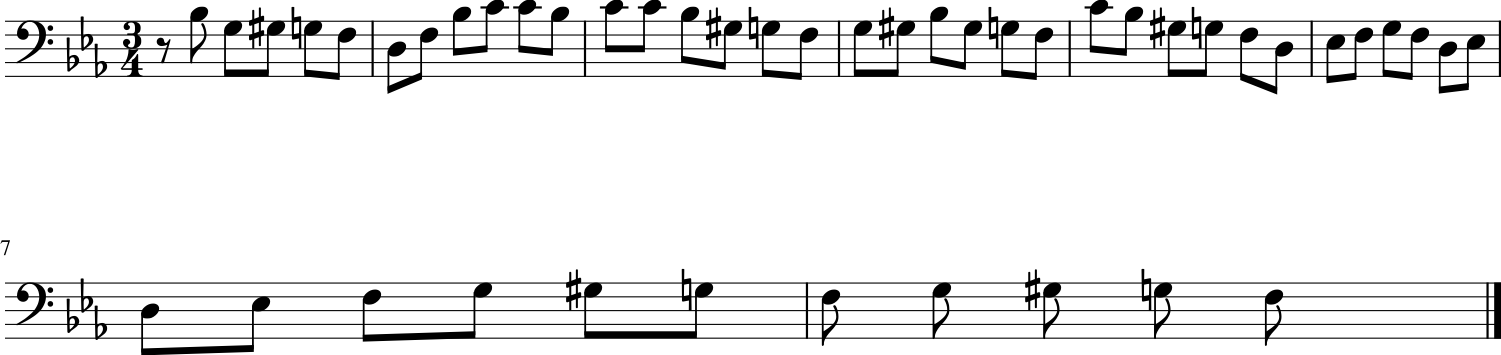

108/108 [==============================] - 13s 118ms/step - loss: 2.9157 - note_outputs_loss: 2.3550 - duration_outputs_loss: 0.5607
Epoch 23/5000
108/108 [==============================] - ETA: 0s - loss: 2.8960 - note_outputs_loss: 2.3402 - duration_outputs_loss: 0.5558[['START', '3/4TS', 'rest', 'rest', 'rest', 'E4', 'rest', 'D4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'D3', 'E3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'D4', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'G3', 'A3'], ['0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


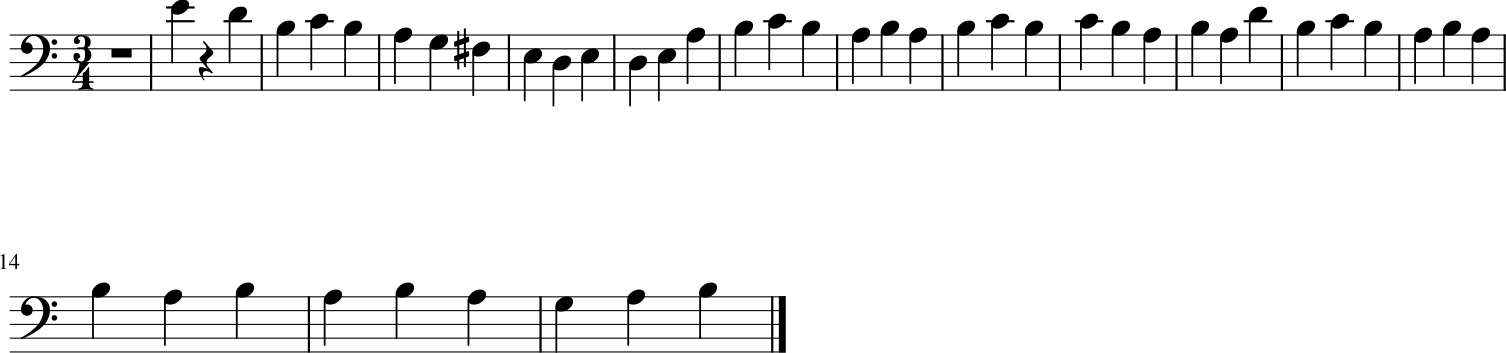

108/108 [==============================] - 13s 119ms/step - loss: 2.8960 - note_outputs_loss: 2.3402 - duration_outputs_loss: 0.5558
Epoch 24/5000
108/108 [==============================] - ETA: 0s - loss: 2.8758 - note_outputs_loss: 2.3265 - duration_outputs_loss: 0.5492[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'D3', 'E-3', 'B-2', 'E-2', 'B-2', 'E-2', 'B-2', 'D3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'D3', 'E-3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


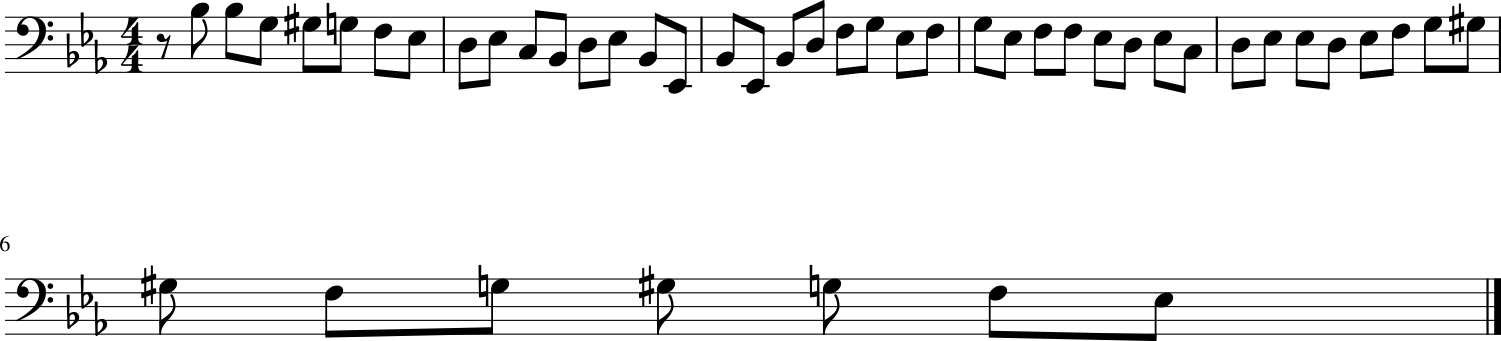

108/108 [==============================] - 13s 119ms/step - loss: 2.8758 - note_outputs_loss: 2.3265 - duration_outputs_loss: 0.5492
Epoch 25/5000
108/108 [==============================] - ETA: 0s - loss: 2.8833 - note_outputs_loss: 2.3292 - duration_outputs_loss: 0.5540[['START', 'C:major', '3/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'A3', 'G#3', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G#3', 'A3'], ['0.0', '0.5', '0.5', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


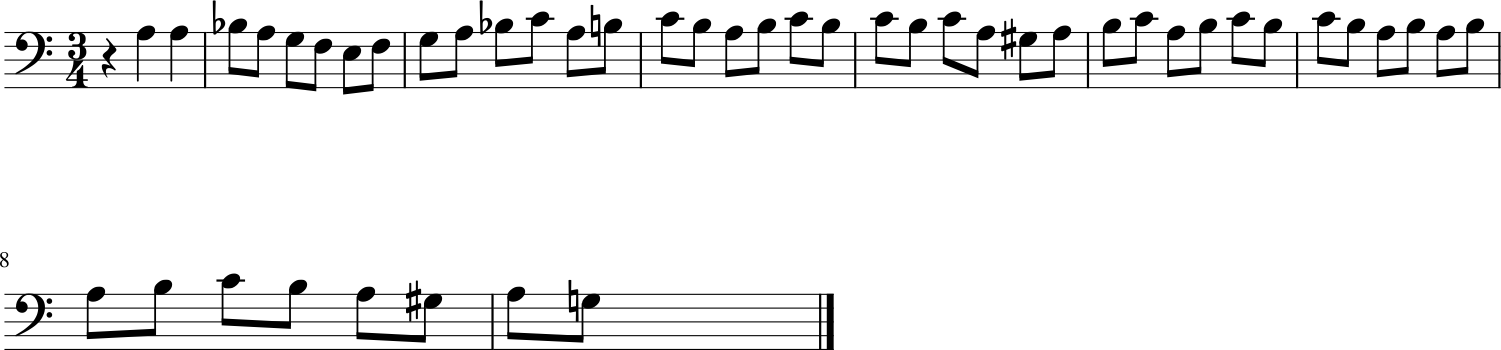

108/108 [==============================] - 15s 136ms/step - loss: 2.8833 - note_outputs_loss: 2.3292 - duration_outputs_loss: 0.5540
Epoch 26/5000
108/108 [==============================] - ETA: 0s - loss: 2.8718 - note_outputs_loss: 2.3152 - duration_outputs_loss: 0.5566[['START', 'G:major', '3/4TS', 'rest', 'D4', 'D4', 'C4', 'C4', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'D4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C#3', 'D3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'B3', 'G3', 'D3', 'B2', 'G2', 'E3', 'D3', 'B2', 'G3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'F#3', 'A3', 'D3'], ['0.0', '0.0', '0.0', '2.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


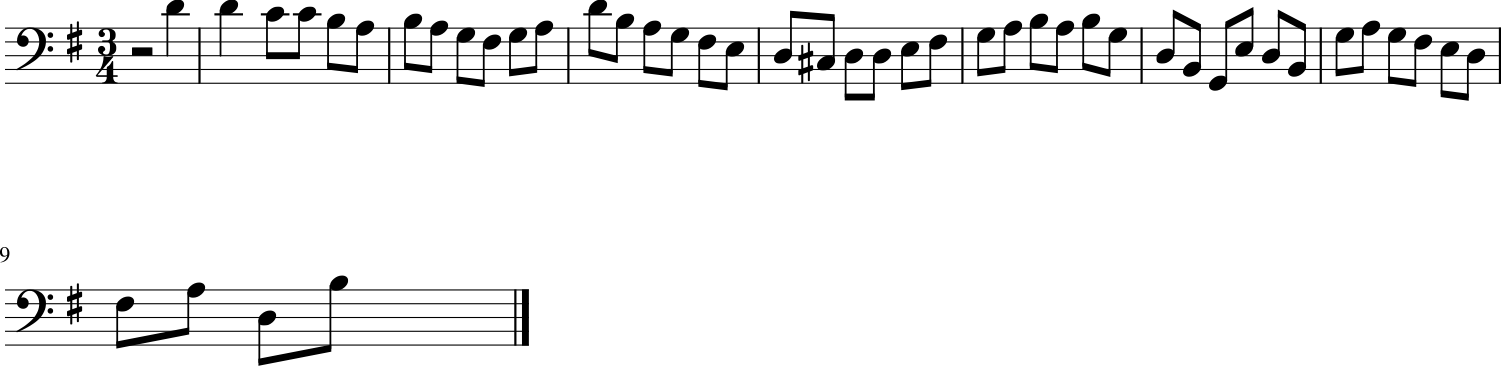

108/108 [==============================] - 13s 121ms/step - loss: 2.8718 - note_outputs_loss: 2.3152 - duration_outputs_loss: 0.5566
Epoch 27/5000
108/108 [==============================] - ETA: 0s - loss: 2.8580 - note_outputs_loss: 2.2992 - duration_outputs_loss: 0.5588[['START', 'F:major', '3/4TS', 'rest', 'D3', 'E3', 'D3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'C4', 'D4', 'B3', 'C4', 'D4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'B3', 'C4', 'E3', 'C3', 'E3', 'F3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


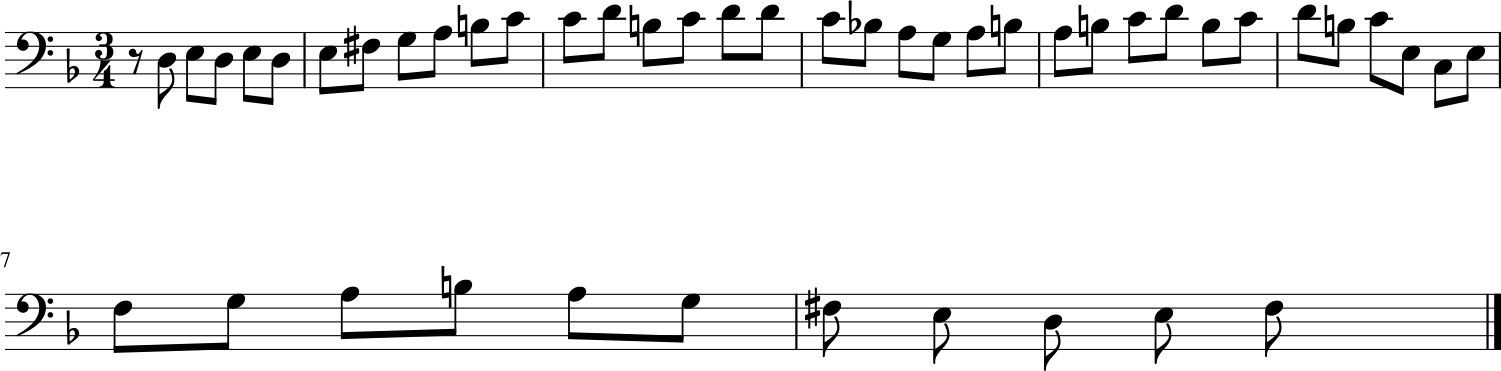

108/108 [==============================] - 13s 120ms/step - loss: 2.8580 - note_outputs_loss: 2.2992 - duration_outputs_loss: 0.5588
Epoch 28/5000
108/108 [==============================] - ETA: 0s - loss: 2.8478 - note_outputs_loss: 2.2980 - duration_outputs_loss: 0.5498[['START', 'E-:major', '3/4TS', 'rest'], ['0.0', '0.0', '0.0', '1.0']]


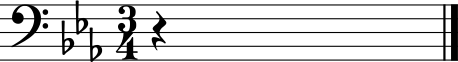

108/108 [==============================] - 8s 78ms/step - loss: 2.8478 - note_outputs_loss: 2.2980 - duration_outputs_loss: 0.5498
Epoch 29/5000
108/108 [==============================] - ETA: 0s - loss: 2.8366 - note_outputs_loss: 2.2777 - duration_outputs_loss: 0.5589[['START', 'E-:major', '3/4TS', 'rest'], ['0.0', '0.0', '0.0', '0.5']]


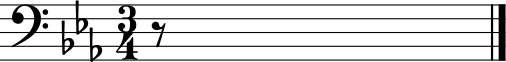

108/108 [==============================] - 8s 78ms/step - loss: 2.8366 - note_outputs_loss: 2.2777 - duration_outputs_loss: 0.5589
Epoch 30/5000
108/108 [==============================] - ETA: 0s - loss: 2.8317 - note_outputs_loss: 2.2728 - duration_outputs_loss: 0.5589[['START', 'E-:major', '3/4TS', 'rest', 'G3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


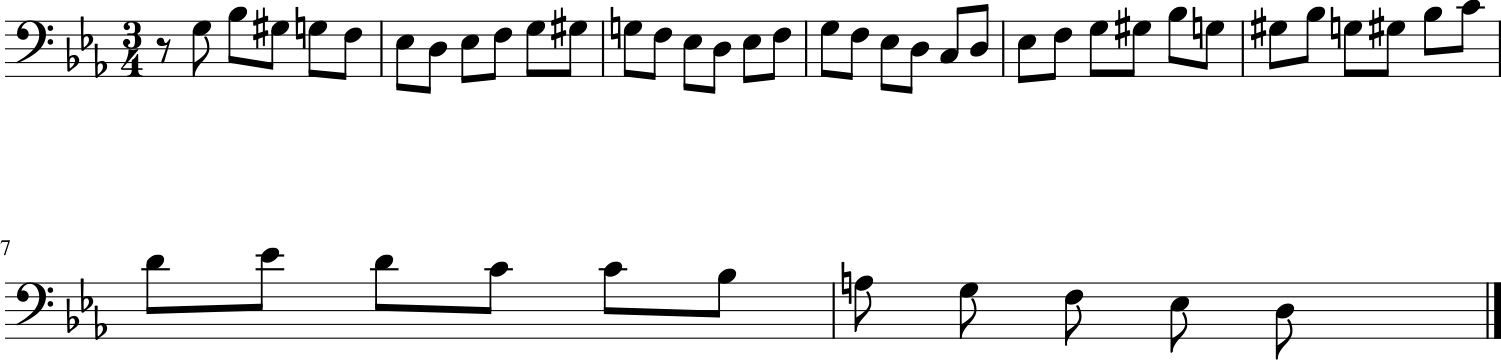

108/108 [==============================] - 13s 119ms/step - loss: 2.8317 - note_outputs_loss: 2.2728 - duration_outputs_loss: 0.5589
Epoch 31/5000
108/108 [==============================] - ETA: 0s - loss: 2.8254 - note_outputs_loss: 2.2682 - duration_outputs_loss: 0.5571[['START', 'E-:major', '3/4TS', 'rest'], ['0.0', '0.5', '0.5', '0.5']]


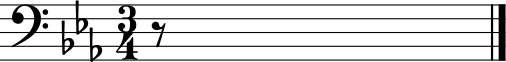

108/108 [==============================] - 9s 83ms/step - loss: 2.8254 - note_outputs_loss: 2.2682 - duration_outputs_loss: 0.5571
Epoch 32/5000
108/108 [==============================] - ETA: 0s - loss: 2.8173 - note_outputs_loss: 2.2578 - duration_outputs_loss: 0.5595[['START', 'E-:major', '3/4TS', 'C4', 'B3', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'D3', 'B-2', 'G2', 'G#2', 'E-2', 'F2', 'F2', 'E-2', 'G2', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


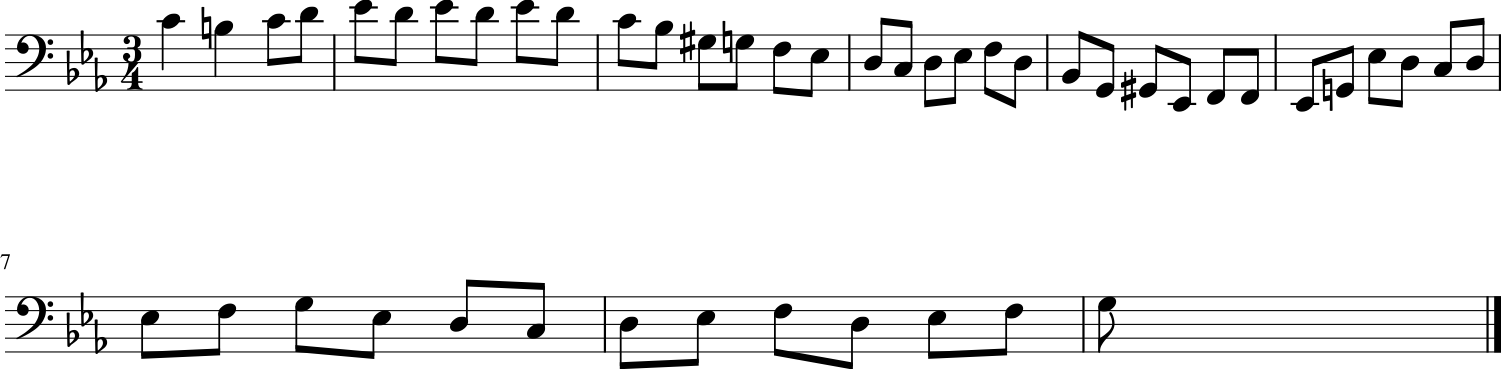

108/108 [==============================] - 13s 119ms/step - loss: 2.8173 - note_outputs_loss: 2.2578 - duration_outputs_loss: 0.5595
Epoch 33/5000
108/108 [==============================] - ETA: 0s - loss: 2.7922 - note_outputs_loss: 2.2417 - duration_outputs_loss: 0.5505[['START', 'G:major', '3/4TS', 'rest', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'B2', 'G2', 'G2', 'D3', 'F#3', 'G3', 'D3', 'E3', 'D3', 'C3', 'B2', 'A2', 'B2', 'C3', 'D3', 'B2', 'G2', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'E3', 'D3', 'E3', 'F3', 'D3', 'B2', 'D3', 'E3', 'F3', 'D3', 'E3', 'D3', 'C3', 'B2'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


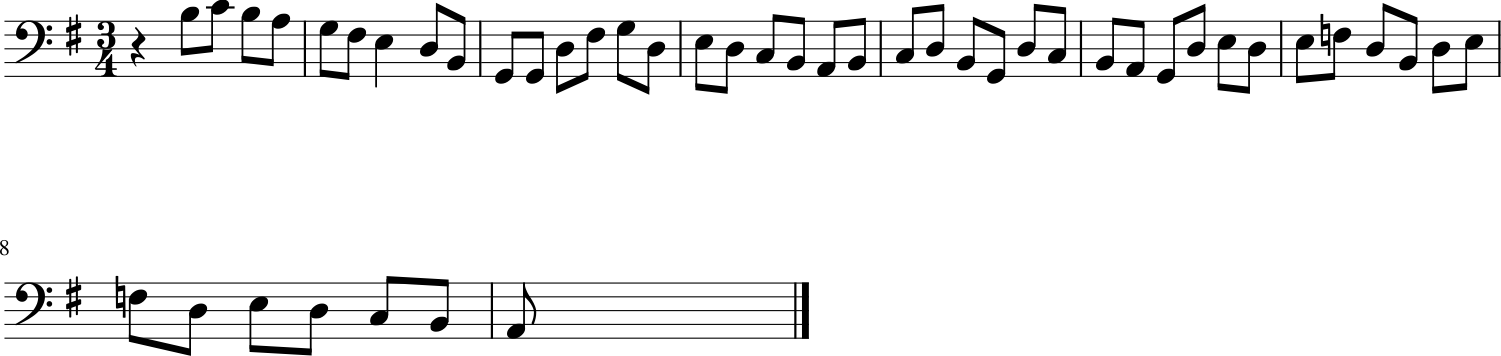

108/108 [==============================] - 13s 119ms/step - loss: 2.7922 - note_outputs_loss: 2.2417 - duration_outputs_loss: 0.5505
Epoch 34/5000
108/108 [==============================] - ETA: 0s - loss: 2.7866 - note_outputs_loss: 2.2351 - duration_outputs_loss: 0.5515[['START', 'F:major', '3/8TS', 'rest', 'D4', 'rest'], ['0.0', '0.0', '0.0', '2.75', '0.25', '0.25']]


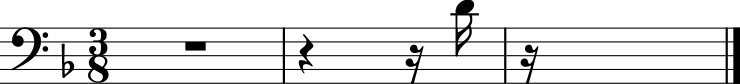

108/108 [==============================] - 9s 79ms/step - loss: 2.7866 - note_outputs_loss: 2.2351 - duration_outputs_loss: 0.5515
Epoch 35/5000
108/108 [==============================] - ETA: 0s - loss: 2.7675 - note_outputs_loss: 2.2183 - duration_outputs_loss: 0.5492[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'F3', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25']]


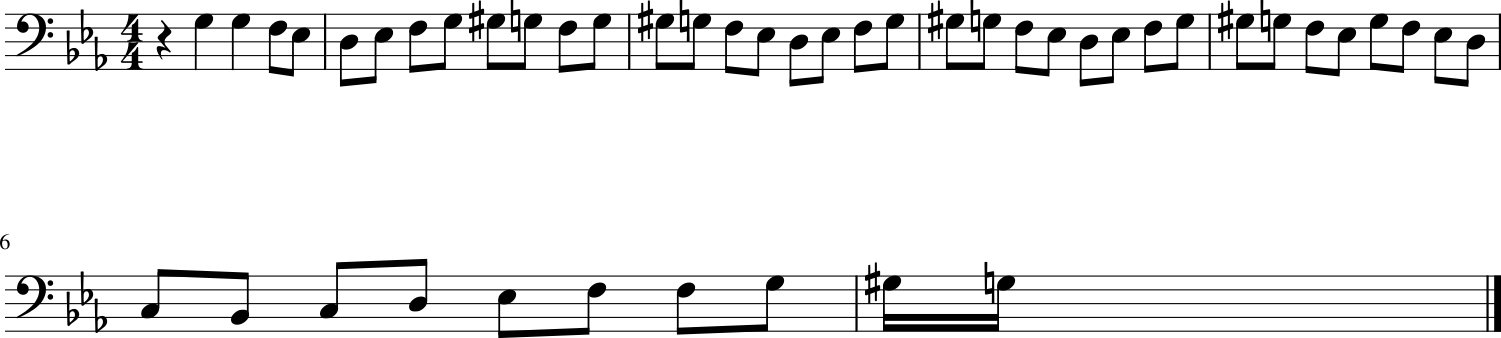

108/108 [==============================] - 13s 119ms/step - loss: 2.7675 - note_outputs_loss: 2.2183 - duration_outputs_loss: 0.5492
Epoch 36/5000
108/108 [==============================] - ETA: 0s - loss: 2.7626 - note_outputs_loss: 2.2171 - duration_outputs_loss: 0.5455[['START', 'D:major', '4/4TS', 'rest', 'A4', 'rest', 'F#4', 'rest', 'A4', 'rest', 'A4', 'A4', 'B4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'E4', 'E4', 'E4', 'F#4', 'E4', 'E4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'C#4', 'B3', 'C#4', 'B3', 'A3', 'G#3', 'F#3', 'E3', 'F#3', 'D3', 'E3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


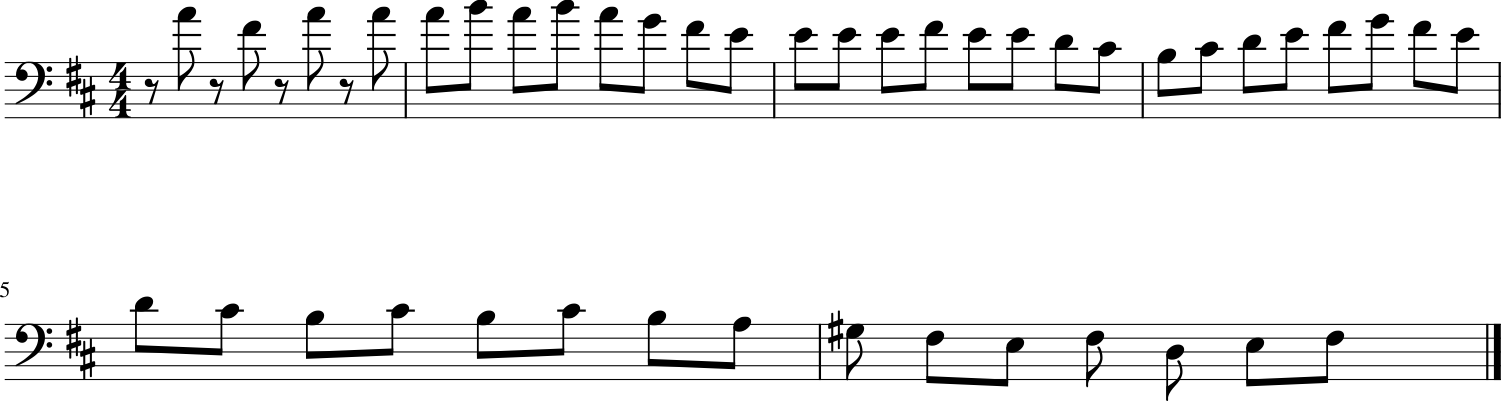

108/108 [==============================] - 14s 132ms/step - loss: 2.7626 - note_outputs_loss: 2.2171 - duration_outputs_loss: 0.5455
Epoch 37/5000
108/108 [==============================] - ETA: 0s - loss: 2.7430 - note_outputs_loss: 2.1981 - duration_outputs_loss: 0.5449[['START', 'E-:major', '4/4TS', 'rest'], ['0.0', '1.0', '1.0', '0.5']]


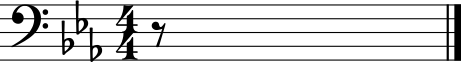

108/108 [==============================] - 8s 77ms/step - loss: 2.7430 - note_outputs_loss: 2.1981 - duration_outputs_loss: 0.5449
Epoch 38/5000
108/108 [==============================] - ETA: 0s - loss: 2.7432 - note_outputs_loss: 2.1946 - duration_outputs_loss: 0.5486[['START', 'F:major', '3/4TS', 'rest', 'D4', 'C#4', 'B-3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G#3', 'B-3', 'C4', 'C#4', 'C#4', 'B-3', 'C#4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'E-3', 'D3', 'C3', 'B-2', 'D2', 'B-3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


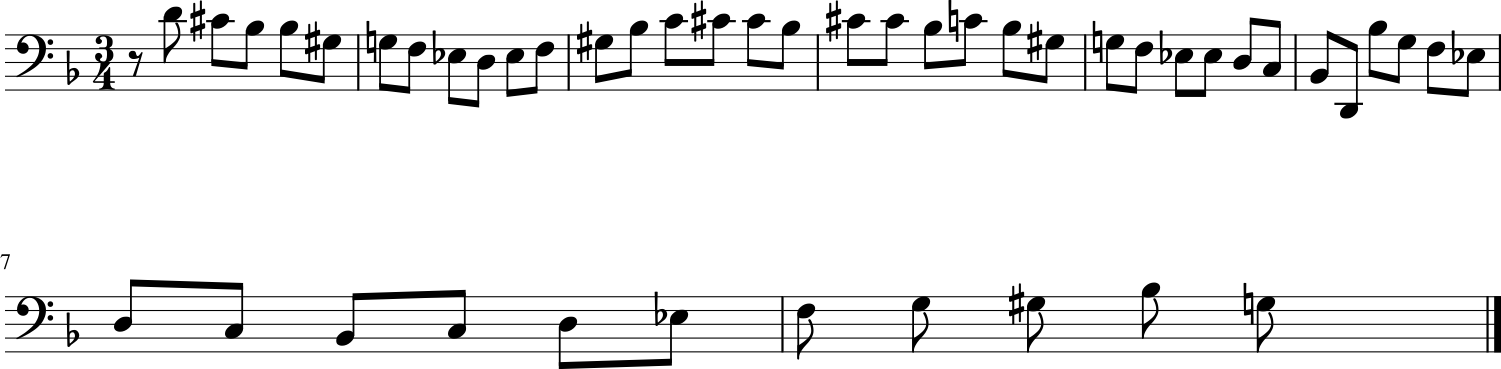

108/108 [==============================] - 14s 127ms/step - loss: 2.7432 - note_outputs_loss: 2.1946 - duration_outputs_loss: 0.5486
Epoch 39/5000
108/108 [==============================] - ETA: 0s - loss: 2.7099 - note_outputs_loss: 2.1677 - duration_outputs_loss: 0.5422[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'B-3', 'G3', 'F3', 'E-3', 'G3', 'F3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


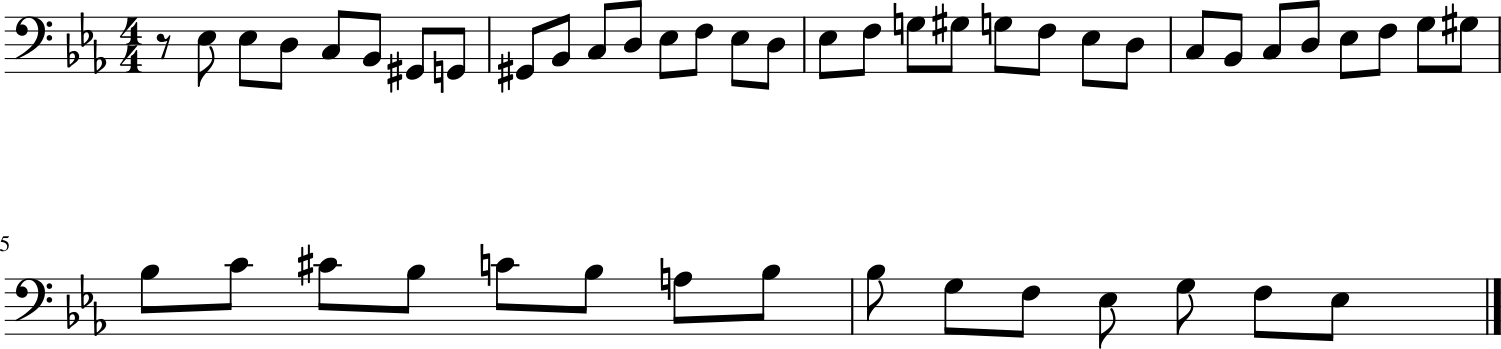

108/108 [==============================] - 13s 120ms/step - loss: 2.7099 - note_outputs_loss: 2.1677 - duration_outputs_loss: 0.5422
Epoch 40/5000
108/108 [==============================] - ETA: 0s - loss: 2.7128 - note_outputs_loss: 2.1665 - duration_outputs_loss: 0.5463[['START', 'D:major', '3/4TS', 'rest', 'rest', 'F#4', 'G4', 'G4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'D4', 'rest', 'F#4', 'rest', 'F#4', 'rest', 'A4', 'rest', 'A3', 'A3', 'rest', 'C#4', 'A3', 'B3', 'C#4', 'D4', 'E4', 'F#4', 'E4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'G#3', 'F#3', 'G#3', 'A3', 'B3', 'A3', 'G3', 'F#3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


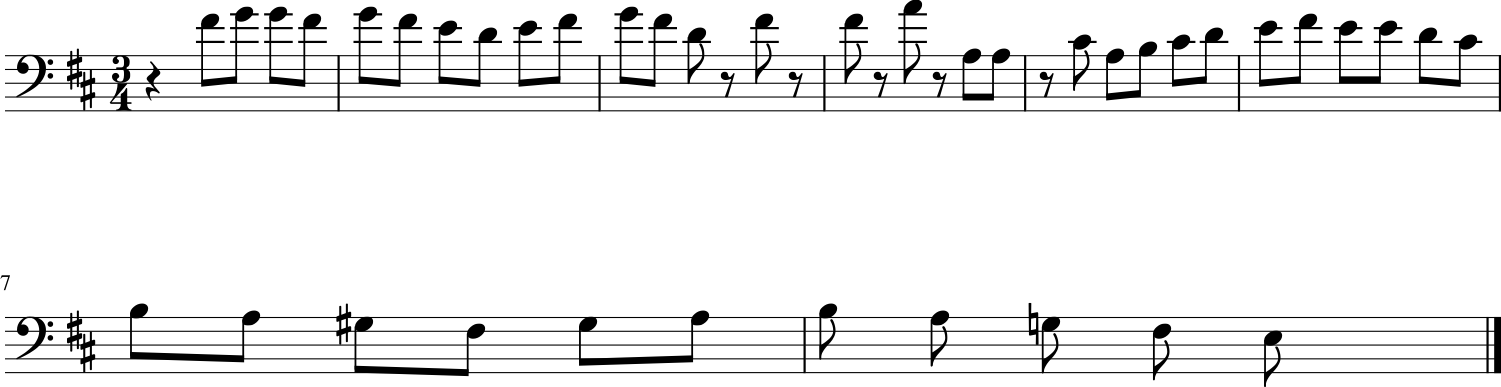

108/108 [==============================] - 13s 119ms/step - loss: 2.7128 - note_outputs_loss: 2.1665 - duration_outputs_loss: 0.5463
Epoch 41/5000
108/108 [==============================] - ETA: 0s - loss: 2.7194 - note_outputs_loss: 2.1617 - duration_outputs_loss: 0.5578[['START', 'C:major', '3/4TS', 'C4', 'B-3', 'A3', 'G3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'D3', 'C3', 'B2', 'D3', 'G3', 'E3', 'F3', 'B2', 'G3', 'F3', 'E3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'E3', 'G3', 'E3', 'F3', 'D3', 'E3', 'F3', 'G3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


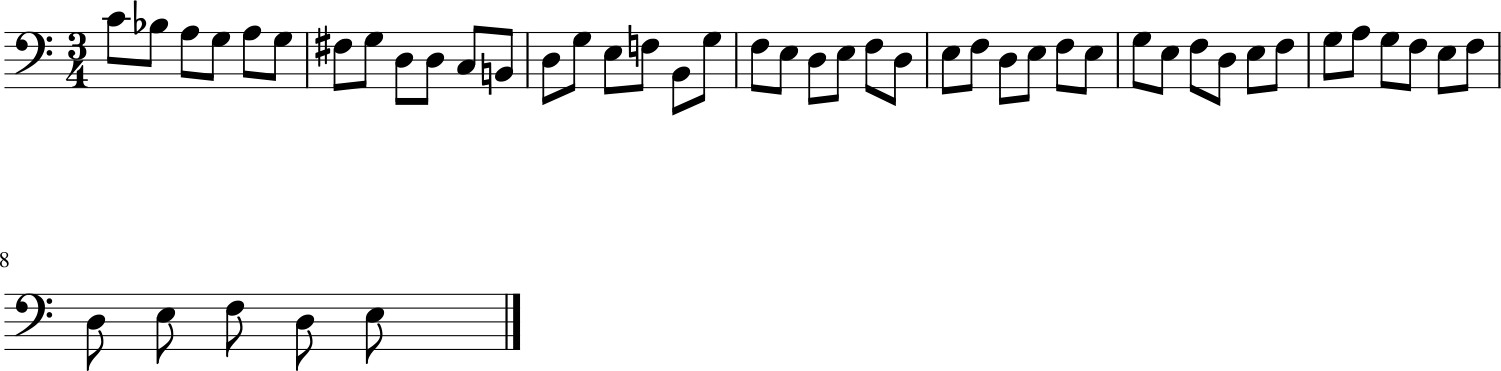

108/108 [==============================] - 13s 124ms/step - loss: 2.7194 - note_outputs_loss: 2.1617 - duration_outputs_loss: 0.5578
Epoch 42/5000
108/108 [==============================] - ETA: 0s - loss: 2.6810 - note_outputs_loss: 2.1384 - duration_outputs_loss: 0.5426[['START', 'D:major', 'C:major', '3/4TS', 'F#3', 'G3', 'A3', 'B3', 'D3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'G3', 'F#3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'G3', 'D3', 'D3', 'B2', 'D3', 'E3', 'F#3', 'G3'], ['0.0', '0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


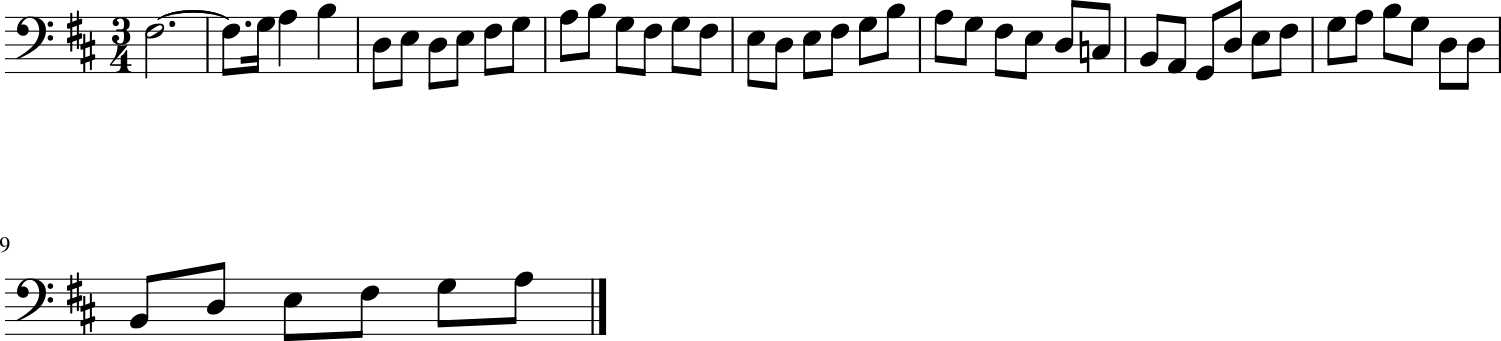

108/108 [==============================] - 13s 120ms/step - loss: 2.6810 - note_outputs_loss: 2.1384 - duration_outputs_loss: 0.5426
Epoch 43/5000
108/108 [==============================] - ETA: 0s - loss: 2.6887 - note_outputs_loss: 2.1361 - duration_outputs_loss: 0.5526[['START', 'D:major', '4/4TS', 'rest', 'B3', 'A4', 'F#4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'E4', 'B3', 'C#4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'C#4', 'B3', 'A3', 'B3', 'C#4', 'D4', 'E4', 'F#4', 'F#4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'G#3', 'F#3', 'E3', 'C#4', 'B3', 'C#4', 'E4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


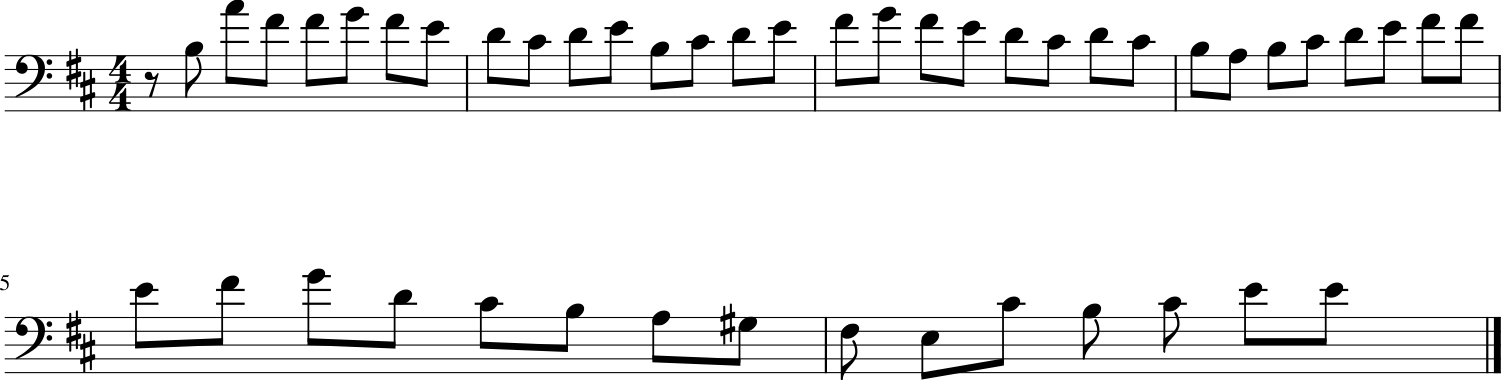

108/108 [==============================] - 13s 120ms/step - loss: 2.6887 - note_outputs_loss: 2.1361 - duration_outputs_loss: 0.5526
Epoch 44/5000
108/108 [==============================] - ETA: 0s - loss: 2.6551 - note_outputs_loss: 2.1097 - duration_outputs_loss: 0.5454[['START', '3/4TS', '3/4TS', 'rest', 'G3', 'rest', 'A3', 'C4', 'B3', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'C#4', 'E4', 'E4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'D4', 'A3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C#4', 'D4', 'E4', 'A3', 'B3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


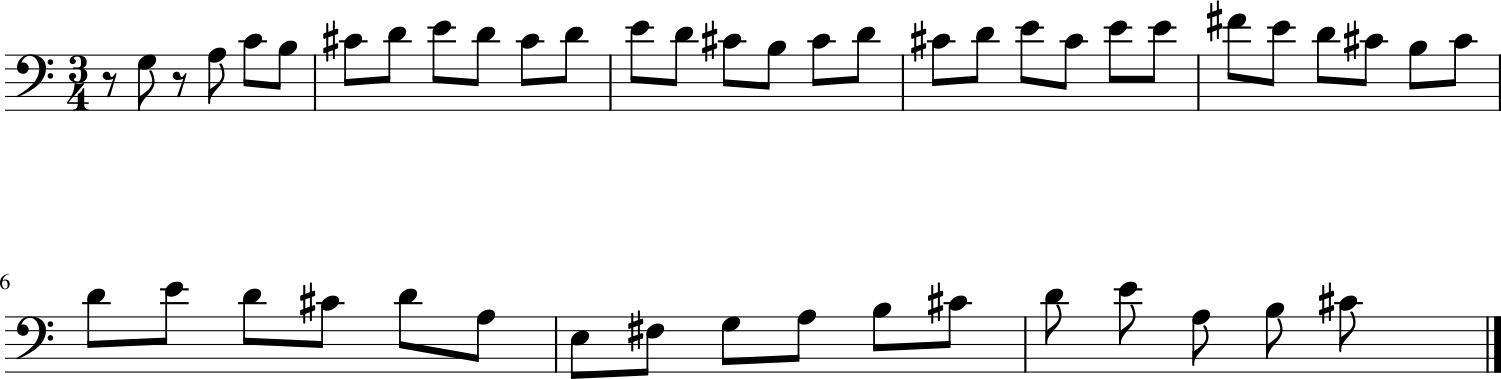

108/108 [==============================] - 13s 119ms/step - loss: 2.6551 - note_outputs_loss: 2.1097 - duration_outputs_loss: 0.5454
Epoch 45/5000
108/108 [==============================] - ETA: 0s - loss: 2.6668 - note_outputs_loss: 2.1152 - duration_outputs_loss: 0.5516[['START', 'D:major', '3/4TS', 'rest', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'G#3', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'A3', 'D4', 'A3', 'D4', 'D4', 'D4', 'D4', 'C#4', 'B3', 'C#4'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


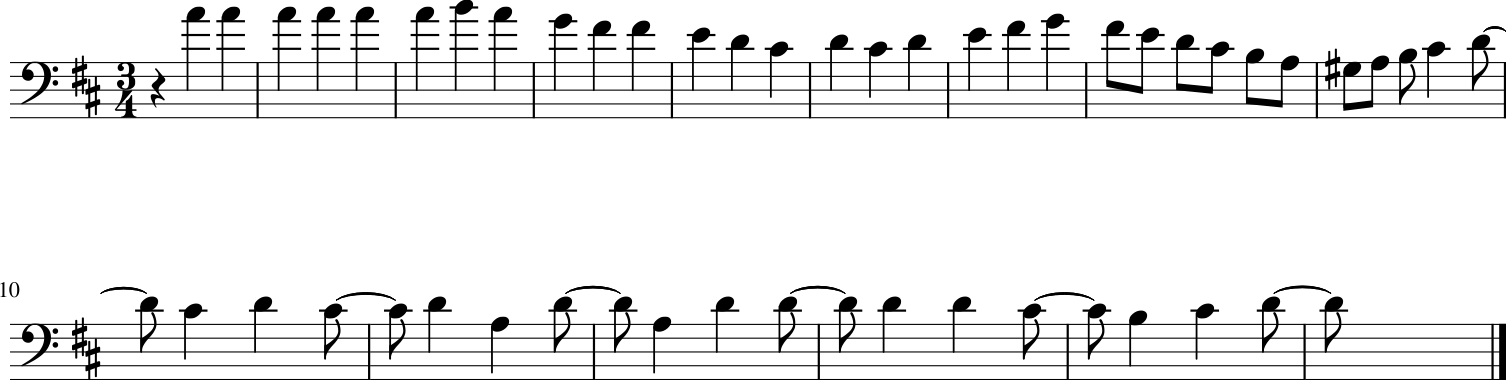

108/108 [==============================] - 16s 145ms/step - loss: 2.6668 - note_outputs_loss: 2.1152 - duration_outputs_loss: 0.5516
Epoch 46/5000
108/108 [==============================] - ETA: 0s - loss: 2.6494 - note_outputs_loss: 2.1067 - duration_outputs_loss: 0.5427[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C4', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'B-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


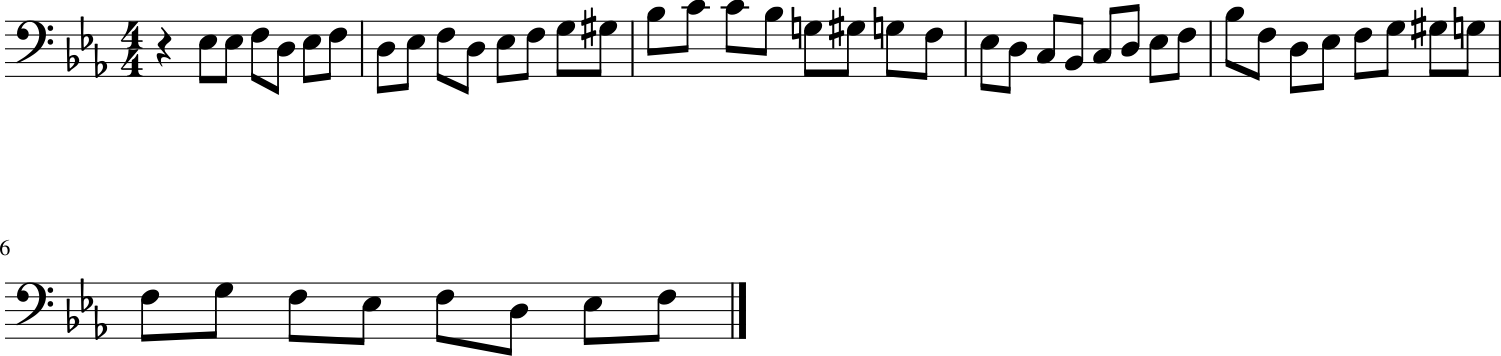

108/108 [==============================] - 13s 119ms/step - loss: 2.6494 - note_outputs_loss: 2.1067 - duration_outputs_loss: 0.5427
Epoch 47/5000
108/108 [==============================] - ETA: 0s - loss: 2.6394 - note_outputs_loss: 2.0942 - duration_outputs_loss: 0.5452[['START', 'E-:major', '4/4TS', 'rest'], ['0.0', '0.0', '0.0', '2.5']]


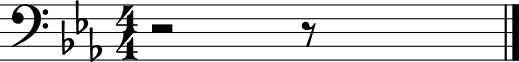

108/108 [==============================] - 9s 78ms/step - loss: 2.6394 - note_outputs_loss: 2.0942 - duration_outputs_loss: 0.5452
Epoch 48/5000
108/108 [==============================] - ETA: 0s - loss: 2.6210 - note_outputs_loss: 2.0803 - duration_outputs_loss: 0.5407[['START', 'D:major', '4/4TS', 'A2', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'E4', 'F#4', 'G#4', 'A4', 'B4', 'A4', 'G#4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'D4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


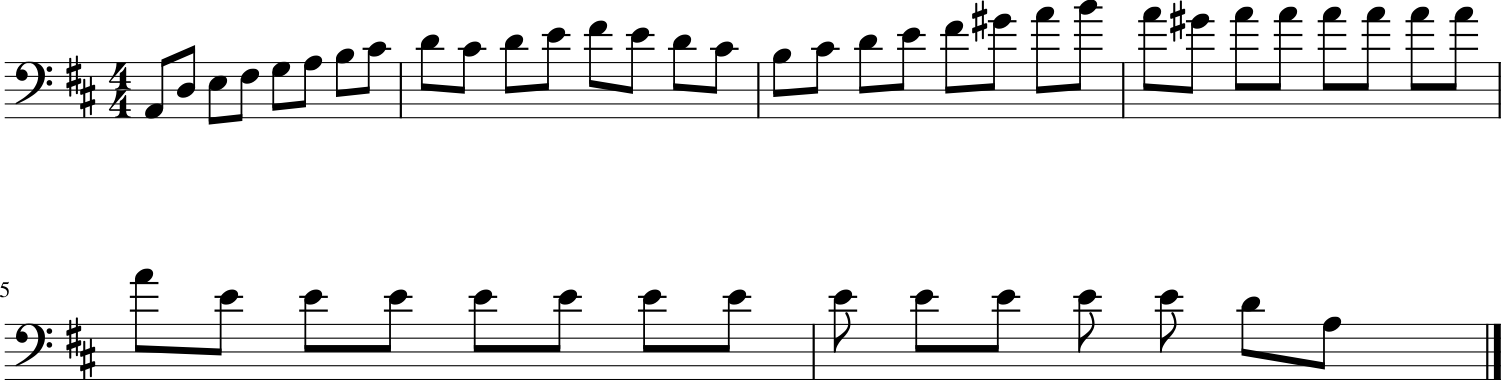

108/108 [==============================] - 13s 120ms/step - loss: 2.6210 - note_outputs_loss: 2.0803 - duration_outputs_loss: 0.5407
Epoch 49/5000
108/108 [==============================] - ETA: 0s - loss: 2.6145 - note_outputs_loss: 2.0709 - duration_outputs_loss: 0.5436[['START', 'D:major', '4/4TS', 'rest', 'A4', 'rest', 'F#4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C#4', 'D4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E3', 'C3', 'G2', 'F2', 'E2', 'F2', 'E2', 'D3', 'F3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E3', 'F3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


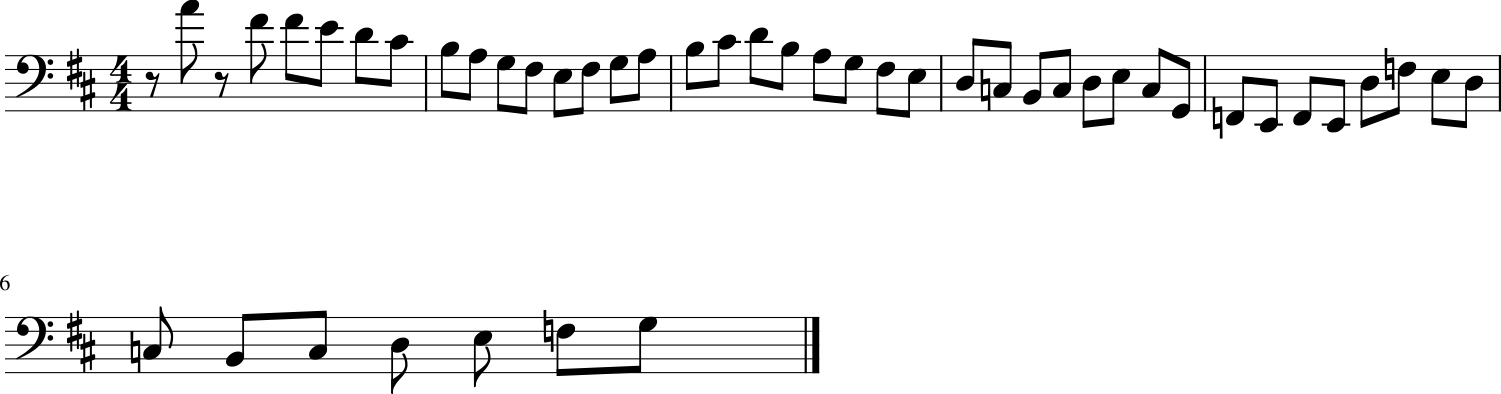

108/108 [==============================] - 14s 130ms/step - loss: 2.6145 - note_outputs_loss: 2.0709 - duration_outputs_loss: 0.5436
Epoch 50/5000
108/108 [==============================] - ETA: 0s - loss: 2.6044 - note_outputs_loss: 2.0612 - duration_outputs_loss: 0.5432[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'G#3', 'C4', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'G#2', 'G2', 'F2', 'G2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'G#2', 'G2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'G#2', 'F2', 'G2', 'G#2', 'F2', 'G2', 'G#2', 'F2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


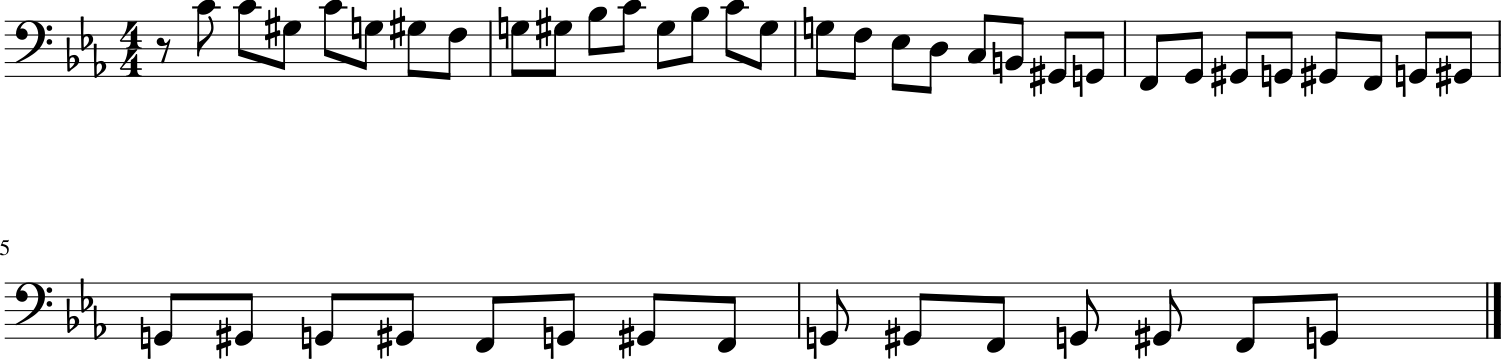

108/108 [==============================] - 15s 137ms/step - loss: 2.6044 - note_outputs_loss: 2.0612 - duration_outputs_loss: 0.5432
Epoch 51/5000
108/108 [==============================] - ETA: 0s - loss: 2.5865 - note_outputs_loss: 2.0480 - duration_outputs_loss: 0.5385[['START', 'G:major', '3/4TS', 'B3', 'A3', 'B3', 'C4', 'B3', 'B3', 'B3', 'D4', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'F#3', 'B3', 'B3', 'B3', 'B3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


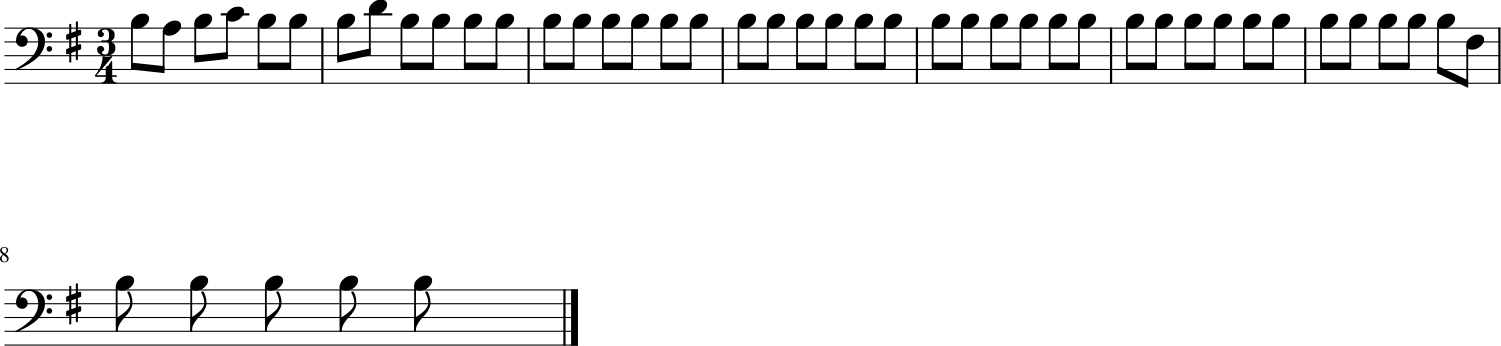

108/108 [==============================] - 13s 119ms/step - loss: 2.5865 - note_outputs_loss: 2.0480 - duration_outputs_loss: 0.5385
Epoch 52/5000
108/108 [==============================] - ETA: 0s - loss: 2.5866 - note_outputs_loss: 2.0443 - duration_outputs_loss: 0.5424[['START', 'E-:major', '3/4TS', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C4', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C4', 'B-3', 'C4', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


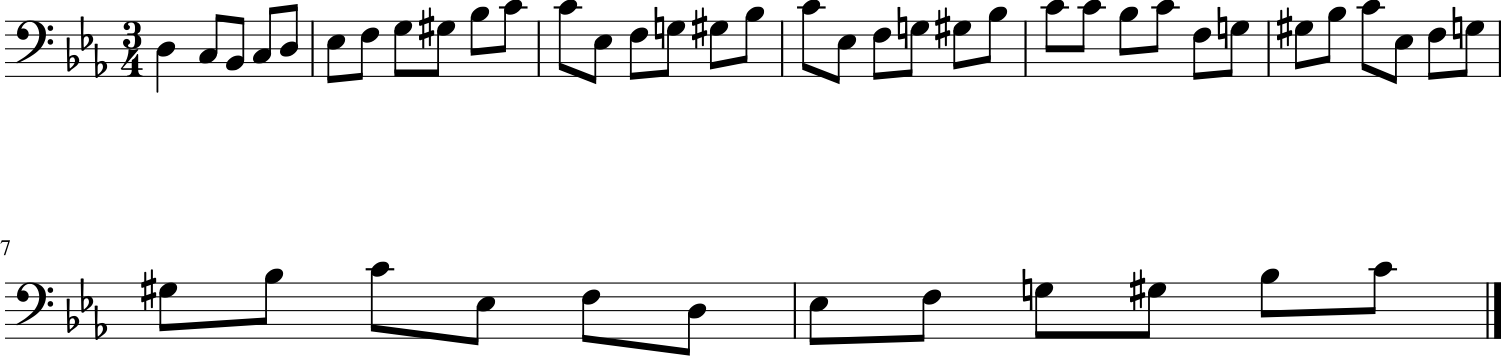

108/108 [==============================] - 13s 120ms/step - loss: 2.5866 - note_outputs_loss: 2.0443 - duration_outputs_loss: 0.5424
Epoch 53/5000
108/108 [==============================] - ETA: 0s - loss: 2.5808 - note_outputs_loss: 2.0335 - duration_outputs_loss: 0.5473[['START', 'G:major', '3/4TS', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'A3', 'B3', 'G3', 'F#3', 'G3', 'E4', 'D4', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'E3', 'D3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'D3', 'C3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


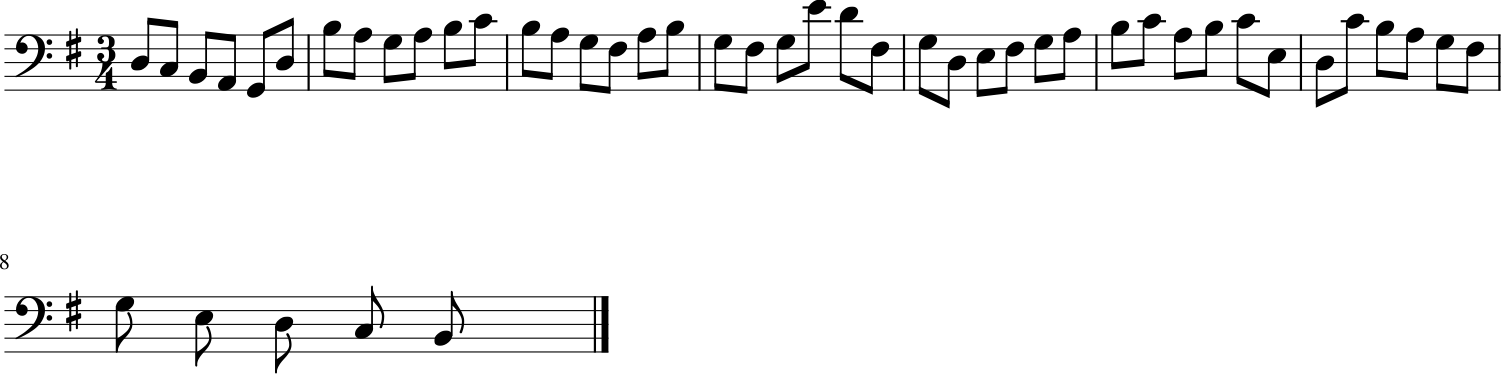

108/108 [==============================] - 13s 119ms/step - loss: 2.5808 - note_outputs_loss: 2.0335 - duration_outputs_loss: 0.5473
Epoch 54/5000
108/108 [==============================] - ETA: 0s - loss: 2.5581 - note_outputs_loss: 2.0147 - duration_outputs_loss: 0.5434[['START', 'F:major', '3/4TS', 'rest', 'A3', 'A3', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'E3', 'G3', 'C4', 'E3', 'A3', 'B3', 'C4', 'E3', 'A3', 'B3', 'C4', 'A3', 'A3', 'G3', 'A3', 'B3', 'C4', 'E3', 'D3', 'C4', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


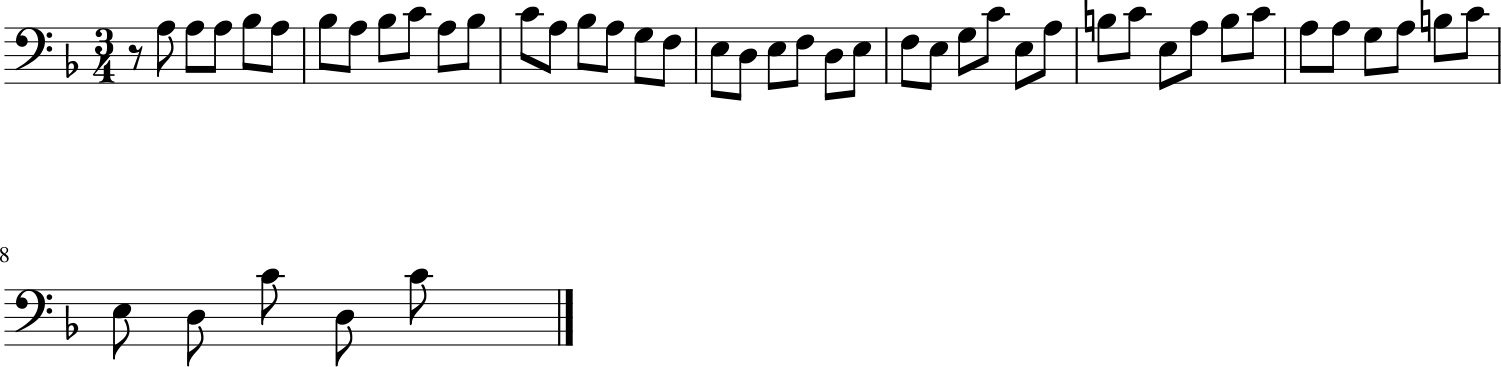

108/108 [==============================] - 14s 131ms/step - loss: 2.5581 - note_outputs_loss: 2.0147 - duration_outputs_loss: 0.5434
Epoch 55/5000
108/108 [==============================] - ETA: 0s - loss: 2.5568 - note_outputs_loss: 2.0122 - duration_outputs_loss: 0.5446[['START', 'G:major', '3/4TS', 'D3', 'B3', 'D3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'D3', 'B2', 'G2', 'A2', 'B2', 'C3', 'D3', 'B2', 'D3', 'G3', 'A3', 'B3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'C#4', 'D4', 'B3', 'G3', 'D3', 'E3', 'F#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3', 'B3', 'C4'], ['0.0', '0.0', '0.0', '2.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


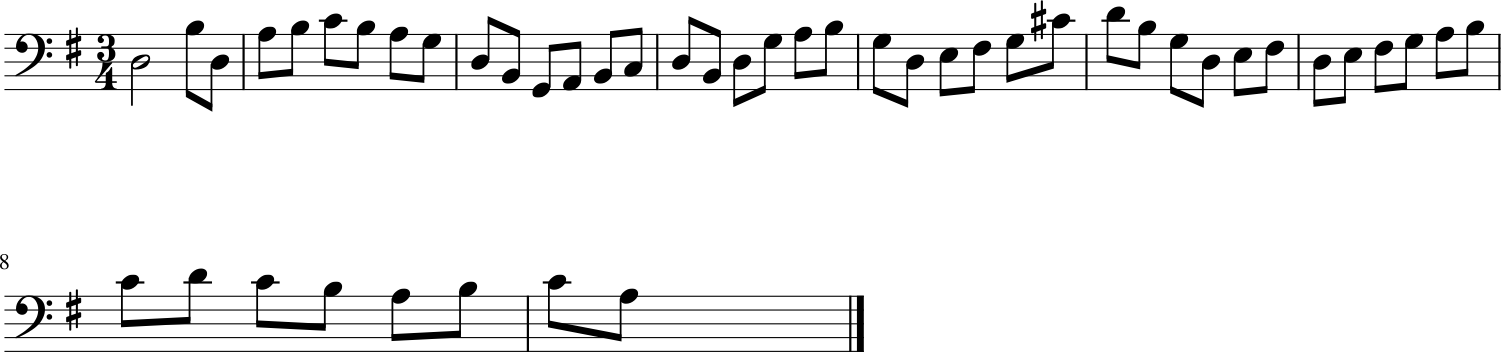

108/108 [==============================] - 13s 119ms/step - loss: 2.5568 - note_outputs_loss: 2.0122 - duration_outputs_loss: 0.5446
Epoch 56/5000
108/108 [==============================] - ETA: 0s - loss: 2.5450 - note_outputs_loss: 2.0014 - duration_outputs_loss: 0.5435[['START', 'G:major', '3/4TS', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'F#3', 'E3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'B3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


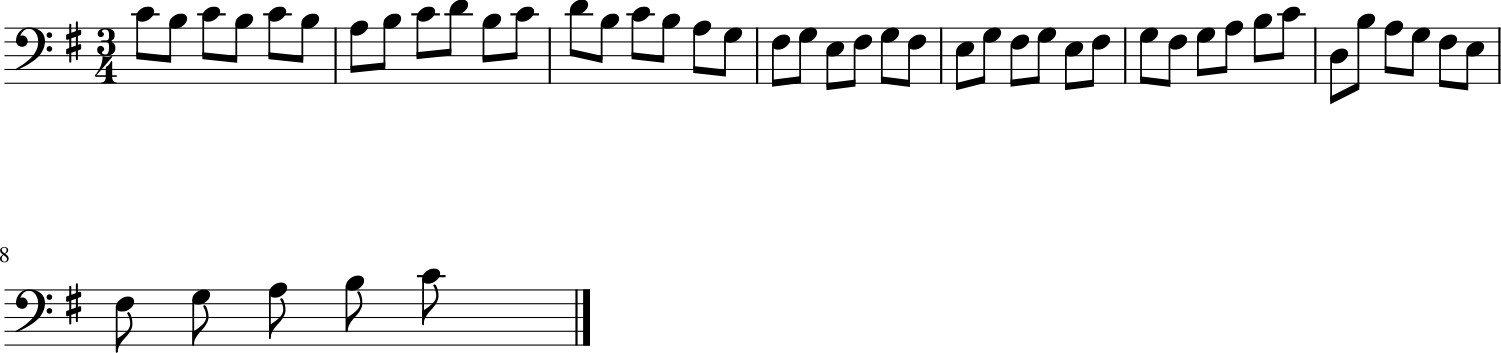

108/108 [==============================] - 13s 120ms/step - loss: 2.5450 - note_outputs_loss: 2.0014 - duration_outputs_loss: 0.5435
Epoch 57/5000
108/108 [==============================] - ETA: 0s - loss: 2.5382 - note_outputs_loss: 1.9926 - duration_outputs_loss: 0.5457[['START', 'G:major', '3/4TS', 'D3', 'B3', 'A3', 'B3', 'G3', 'D3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'F#3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'G2', 'G2', 'A2', 'B2', 'F2', 'E2', 'D3', 'C#3', 'B2', 'A2', 'G2'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


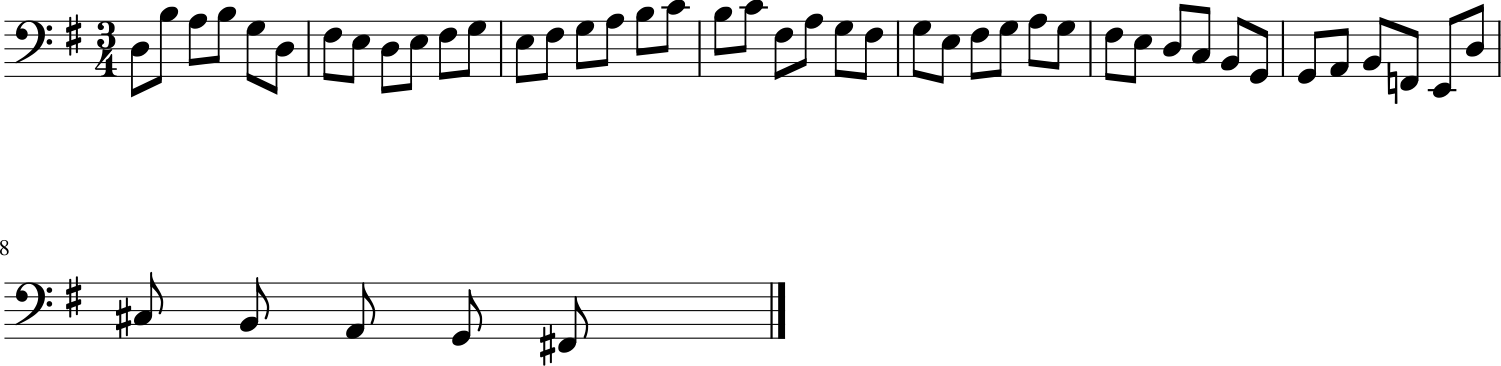

108/108 [==============================] - 13s 120ms/step - loss: 2.5382 - note_outputs_loss: 1.9926 - duration_outputs_loss: 0.5457
Epoch 58/5000
108/108 [==============================] - ETA: 0s - loss: 2.5189 - note_outputs_loss: 1.9760 - duration_outputs_loss: 0.5429[['START', 'C:major', '3/4TS', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'G3', 'C3', 'B2', 'C3', 'D3', 'G2', 'D3', 'B3', 'C4', 'G3', 'A3', 'B3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'C3', 'B2'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


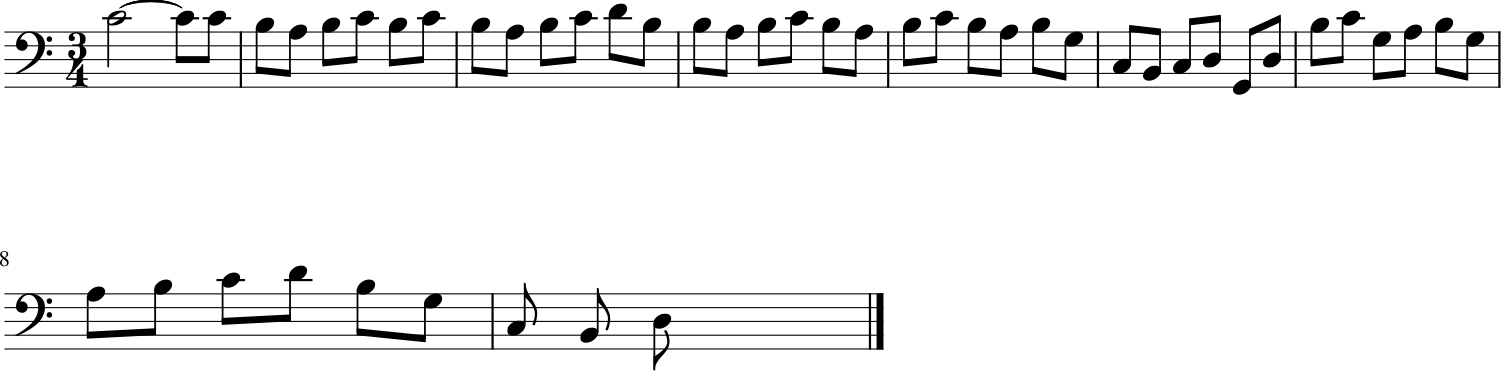

108/108 [==============================] - 13s 124ms/step - loss: 2.5189 - note_outputs_loss: 1.9760 - duration_outputs_loss: 0.5429
Epoch 59/5000
108/108 [==============================] - ETA: 0s - loss: 2.5139 - note_outputs_loss: 1.9656 - duration_outputs_loss: 0.5483[['START', 'G:major', '3/4TS', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'G3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


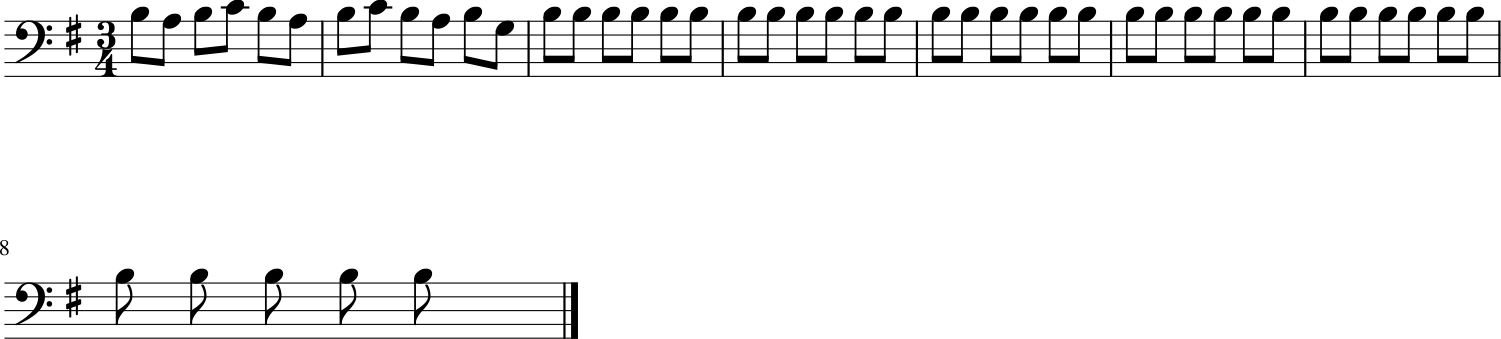

108/108 [==============================] - 14s 132ms/step - loss: 2.5139 - note_outputs_loss: 1.9656 - duration_outputs_loss: 0.5483
Epoch 60/5000
108/108 [==============================] - ETA: 0s - loss: 2.5086 - note_outputs_loss: 1.9583 - duration_outputs_loss: 0.5503[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'B-3', 'G3', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


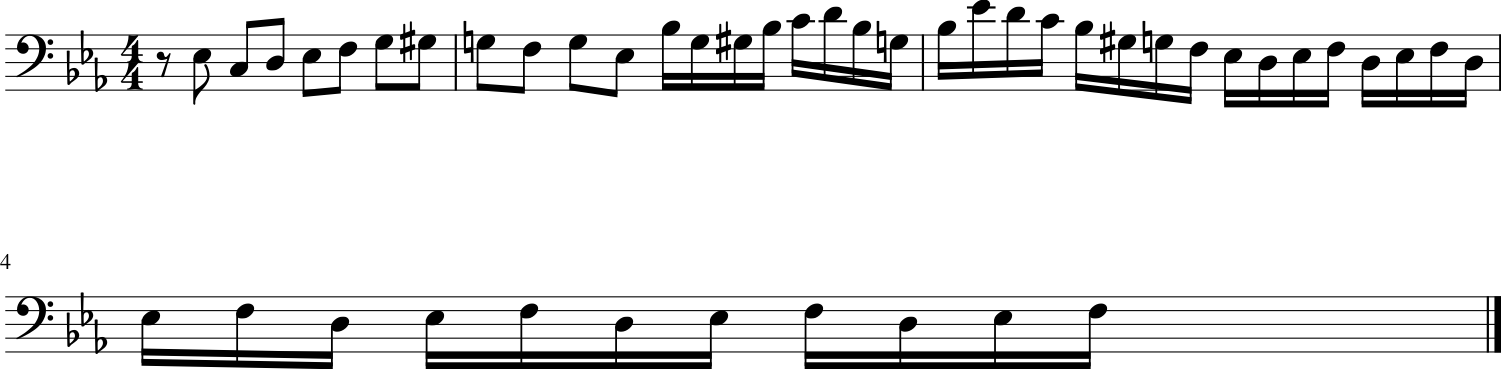

108/108 [==============================] - 13s 122ms/step - loss: 2.5086 - note_outputs_loss: 1.9583 - duration_outputs_loss: 0.5503
Epoch 61/5000
108/108 [==============================] - ETA: 0s - loss: 2.4963 - note_outputs_loss: 1.9517 - duration_outputs_loss: 0.5446[['START', 'G:major', '3/4TS', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'B2', 'C3', 'D3', 'G2', 'D3', 'F#3', 'A3', 'C4', 'B3', 'A3', 'B3', 'D3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E3', 'F#3', 'G3', 'C3', 'D3', 'B2', 'D3', 'G3', 'B2', 'D3', 'G3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'A3'], ['0.0', '0.0', '0.5', '0.5', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


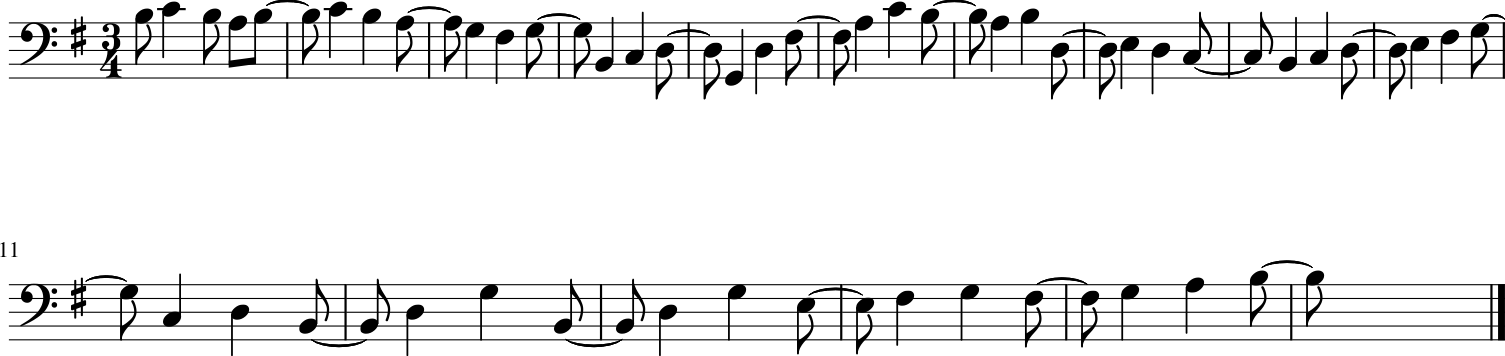

108/108 [==============================] - 13s 121ms/step - loss: 2.4963 - note_outputs_loss: 1.9517 - duration_outputs_loss: 0.5446
Epoch 62/5000
108/108 [==============================] - ETA: 0s - loss: 2.4934 - note_outputs_loss: 1.9503 - duration_outputs_loss: 0.5430[['START', 'F:major', '3/4TS', 'D3', 'E3', 'F3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'F2', 'E2', 'C#3', 'D3', 'E3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'G#3', 'F3', 'G#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


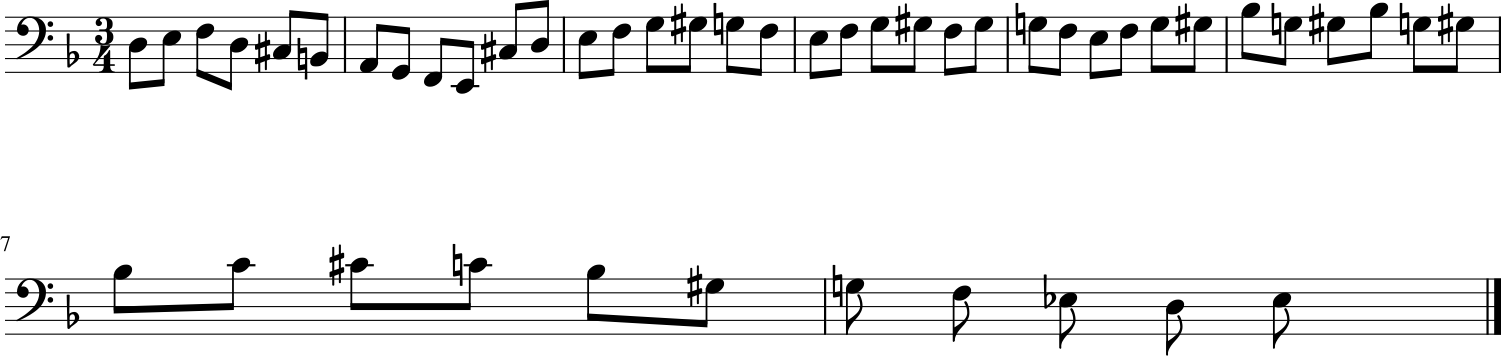

108/108 [==============================] - 16s 144ms/step - loss: 2.4934 - note_outputs_loss: 1.9503 - duration_outputs_loss: 0.5430
Epoch 63/5000
108/108 [==============================] - ETA: 0s - loss: 2.4724 - note_outputs_loss: 1.9293 - duration_outputs_loss: 0.5431[['START', 'G:major', '3/4TS', 'D3', 'G2', 'D3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'G2', 'D3', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'F3', 'A3', 'D4', 'A3', 'F#3', 'G3', 'D3', 'G2', 'D3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'C3', 'G2'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


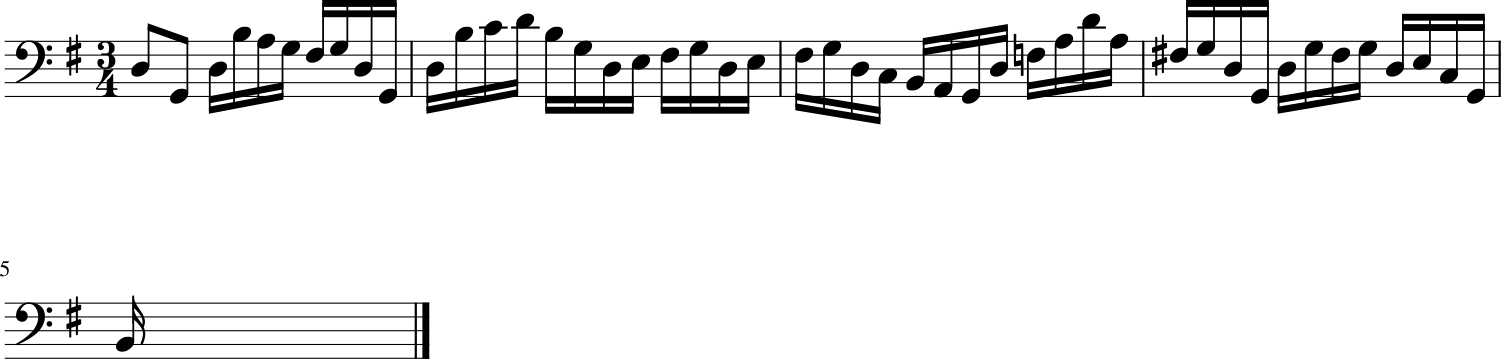

108/108 [==============================] - 13s 120ms/step - loss: 2.4724 - note_outputs_loss: 1.9293 - duration_outputs_loss: 0.5431
Epoch 64/5000
108/108 [==============================] - ETA: 0s - loss: 2.4677 - note_outputs_loss: 1.9232 - duration_outputs_loss: 0.5445[['START', 'G:major', '3/4TS', 'rest', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'D3', 'G2', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'A2', 'B2', 'C3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'C3', 'D3', 'E-3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


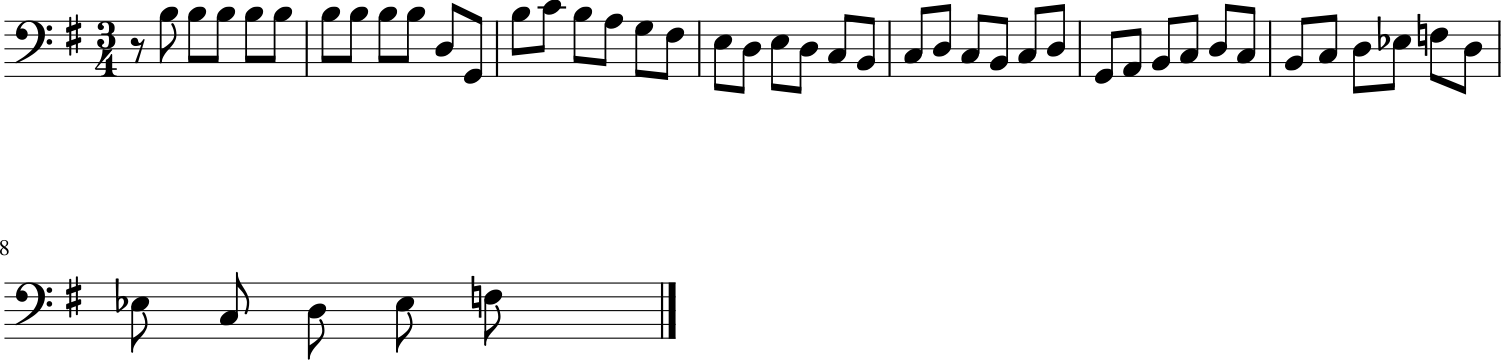

108/108 [==============================] - 13s 120ms/step - loss: 2.4677 - note_outputs_loss: 1.9232 - duration_outputs_loss: 0.5445
Epoch 65/5000
108/108 [==============================] - ETA: 0s - loss: 2.4597 - note_outputs_loss: 1.9159 - duration_outputs_loss: 0.5438[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'A3', 'B-3', 'G3', 'C3', 'G3', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


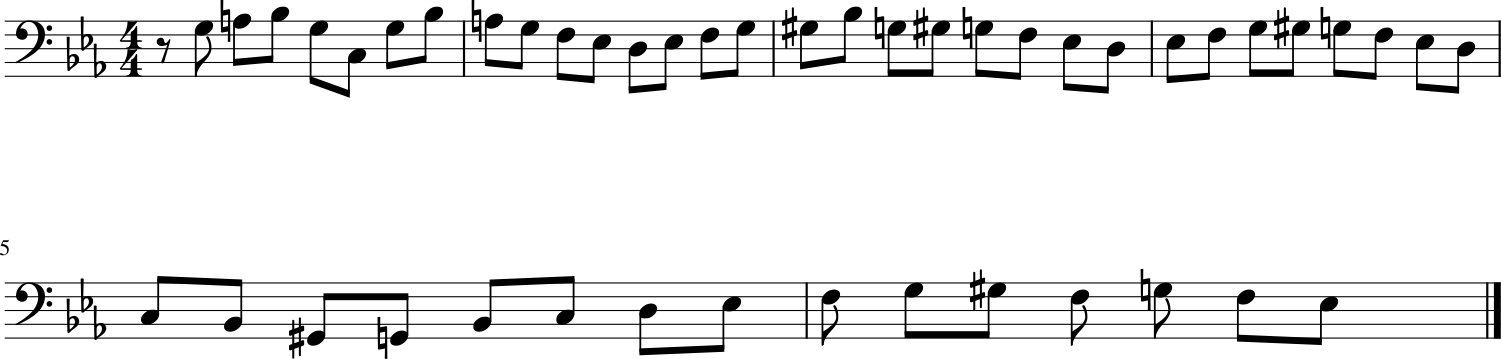

108/108 [==============================] - 13s 120ms/step - loss: 2.4597 - note_outputs_loss: 1.9159 - duration_outputs_loss: 0.5438
Epoch 66/5000
108/108 [==============================] - ETA: 0s - loss: 2.4526 - note_outputs_loss: 1.9110 - duration_outputs_loss: 0.5416[['START', 'G:major', '3/4TS', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3', 'G3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


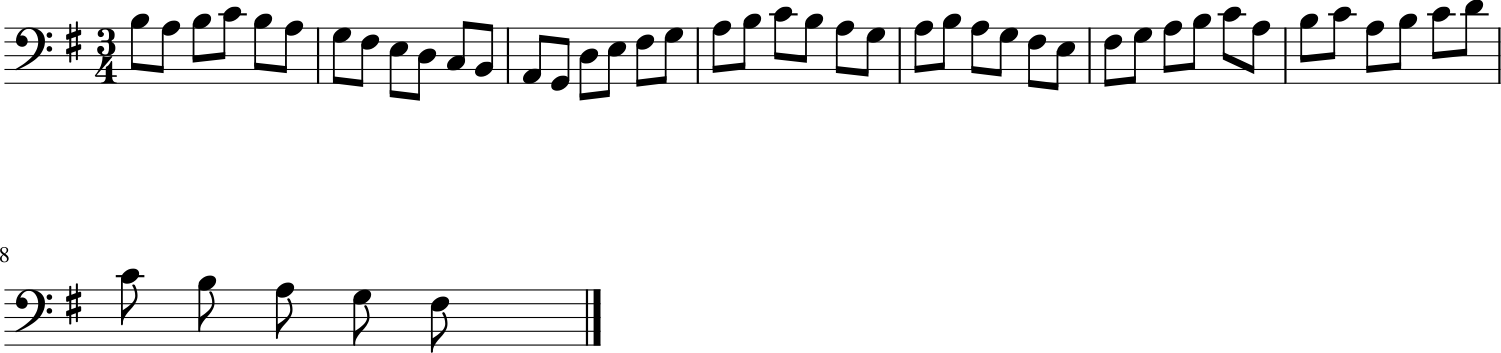

108/108 [==============================] - 13s 119ms/step - loss: 2.4526 - note_outputs_loss: 1.9110 - duration_outputs_loss: 0.5416
Epoch 67/5000
108/108 [==============================] - ETA: 0s - loss: 2.4363 - note_outputs_loss: 1.8971 - duration_outputs_loss: 0.5391[['START', 'F:major', '3/4TS', 'D3', 'E3', 'F3', 'D3', 'G3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'C3', 'B-2', 'C3', 'D3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


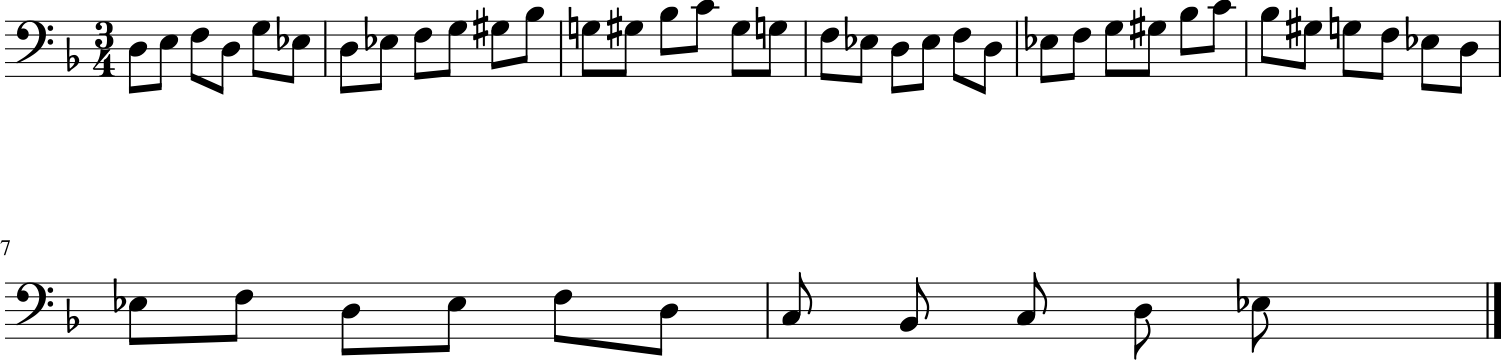

108/108 [==============================] - 14s 129ms/step - loss: 2.4363 - note_outputs_loss: 1.8971 - duration_outputs_loss: 0.5391
Epoch 68/5000
108/108 [==============================] - ETA: 0s - loss: 2.4281 - note_outputs_loss: 1.8853 - duration_outputs_loss: 0.5428[['START', 'F:major', '4/4TS', 'rest', 'C#4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


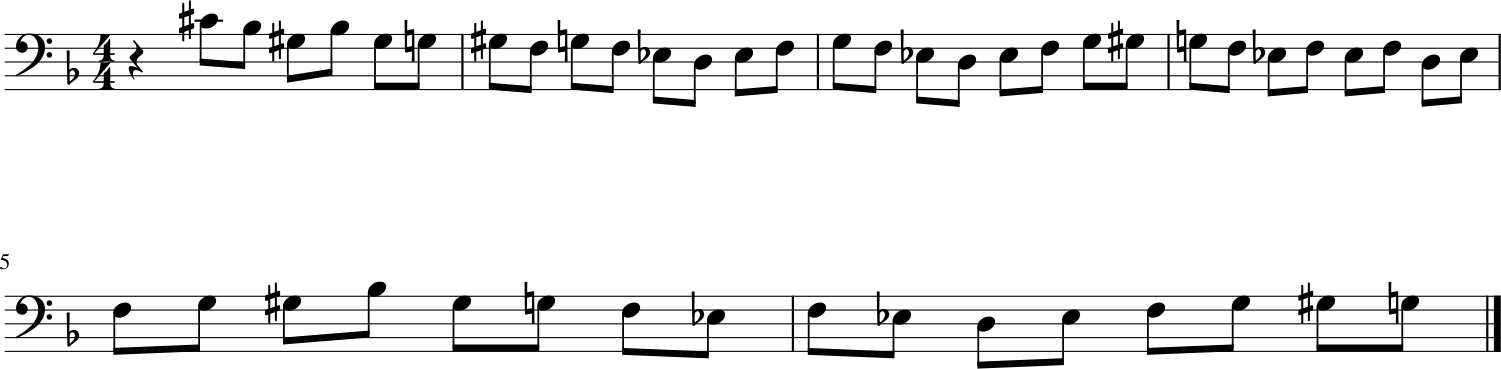

108/108 [==============================] - 13s 119ms/step - loss: 2.4281 - note_outputs_loss: 1.8853 - duration_outputs_loss: 0.5428
Epoch 69/5000
108/108 [==============================] - ETA: 0s - loss: 2.4243 - note_outputs_loss: 1.8805 - duration_outputs_loss: 0.5438[['START', 'G:major', '3/4TS', 'B3', 'A3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


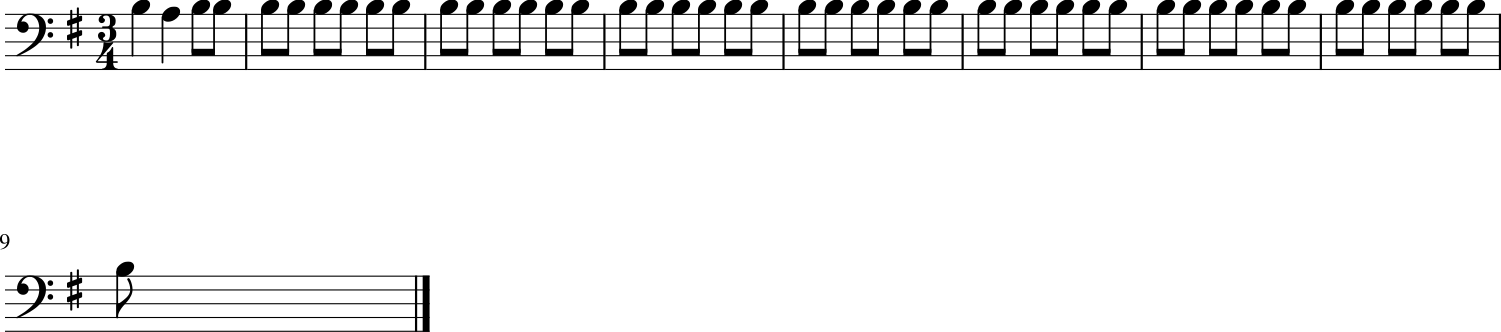

108/108 [==============================] - 14s 130ms/step - loss: 2.4243 - note_outputs_loss: 1.8805 - duration_outputs_loss: 0.5438
Epoch 70/5000
108/108 [==============================] - ETA: 0s - loss: 2.4179 - note_outputs_loss: 1.8723 - duration_outputs_loss: 0.5456[['START', 'E-:major', '3/4TS', 'rest', 'E-3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'C3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'C3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


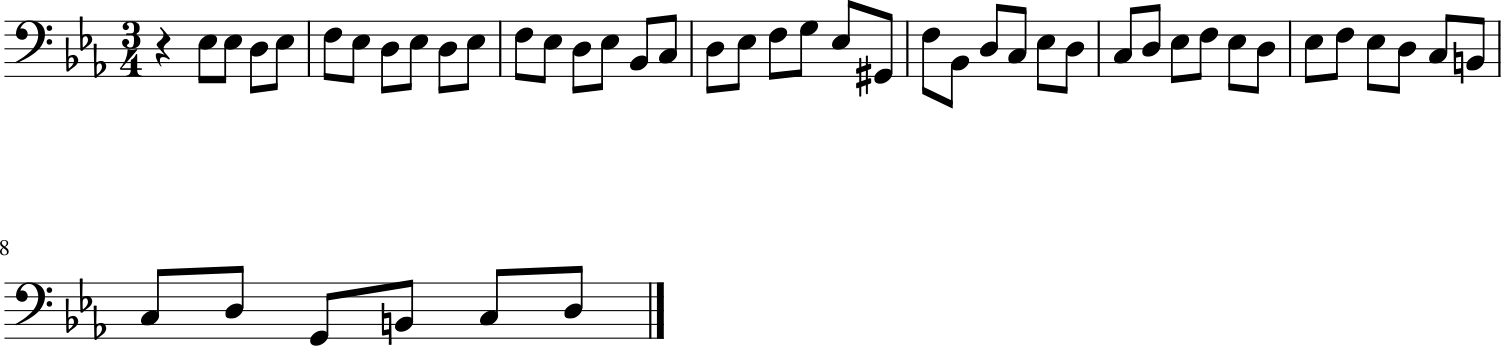

108/108 [==============================] - 13s 121ms/step - loss: 2.4179 - note_outputs_loss: 1.8723 - duration_outputs_loss: 0.5456
Epoch 71/5000
108/108 [==============================] - ETA: 0s - loss: 2.4079 - note_outputs_loss: 1.8649 - duration_outputs_loss: 0.5430[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'G3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


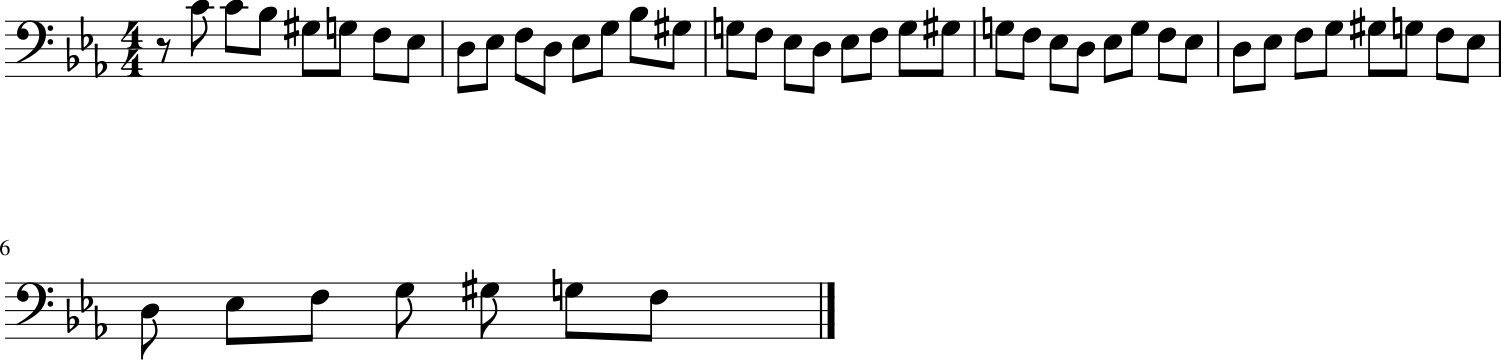

108/108 [==============================] - 16s 146ms/step - loss: 2.4079 - note_outputs_loss: 1.8649 - duration_outputs_loss: 0.5430
Epoch 72/5000
108/108 [==============================] - ETA: 0s - loss: 2.4015 - note_outputs_loss: 1.8571 - duration_outputs_loss: 0.5443[['START', 'D:major', '12/8TS', 'rest', 'D3', 'A2', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'A3', 'F#3', 'D3', 'E3', 'F#3', 'D4', 'B2', 'C#3', 'D3', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'D3', 'C3', 'B2'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


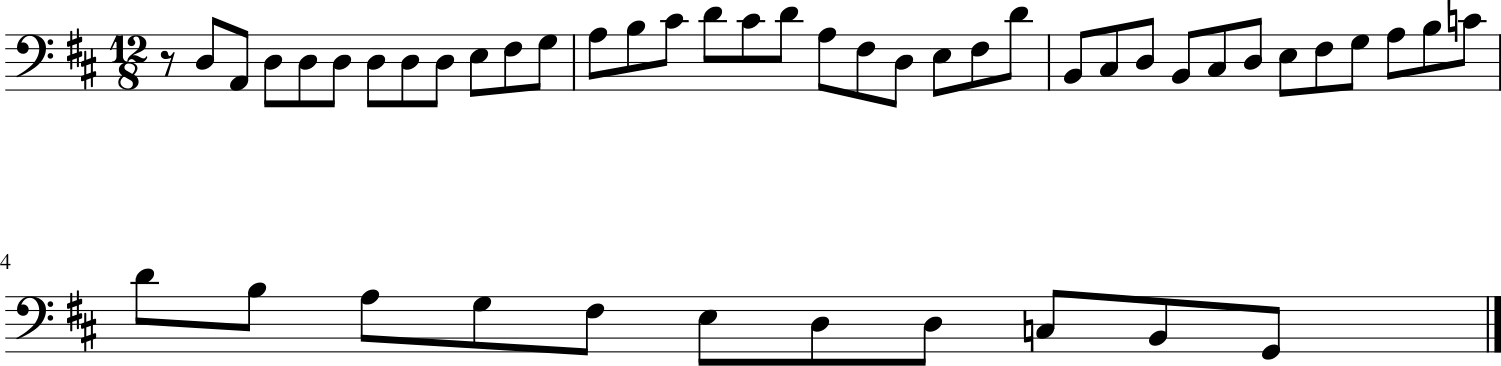

108/108 [==============================] - 13s 119ms/step - loss: 2.4015 - note_outputs_loss: 1.8571 - duration_outputs_loss: 0.5443
Epoch 73/5000
108/108 [==============================] - ETA: 0s - loss: 2.3927 - note_outputs_loss: 1.8492 - duration_outputs_loss: 0.5435[['START', 'C:major', '3/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


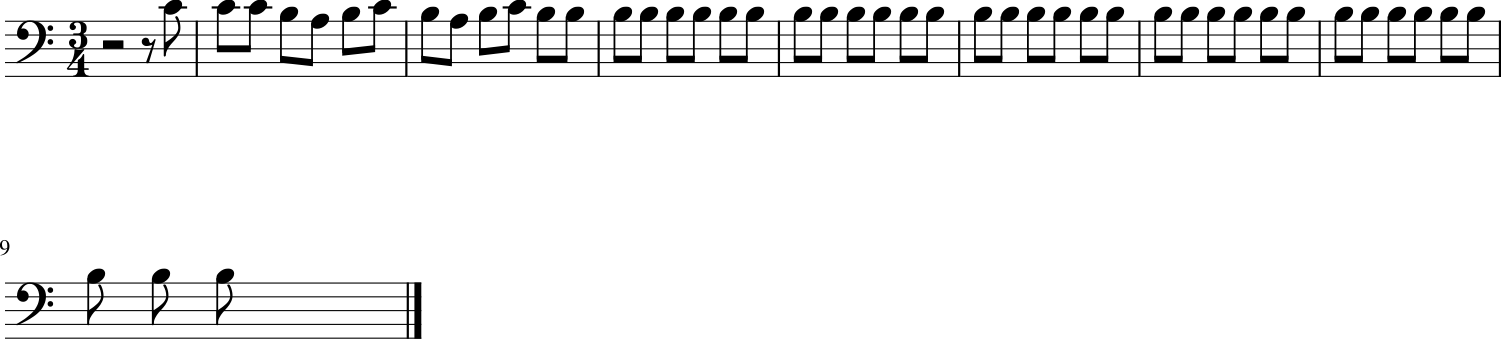

108/108 [==============================] - 13s 120ms/step - loss: 2.3927 - note_outputs_loss: 1.8492 - duration_outputs_loss: 0.5435
Epoch 74/5000
108/108 [==============================] - ETA: 0s - loss: 2.3872 - note_outputs_loss: 1.8402 - duration_outputs_loss: 0.5471[['START', 'D:major', '12/8TS', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D4', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'F#3', 'D3', 'F#3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'A3', 'A3', 'B3', 'A3', 'B3', 'C4', 'A3', 'B3', 'A3', 'B3', 'A3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


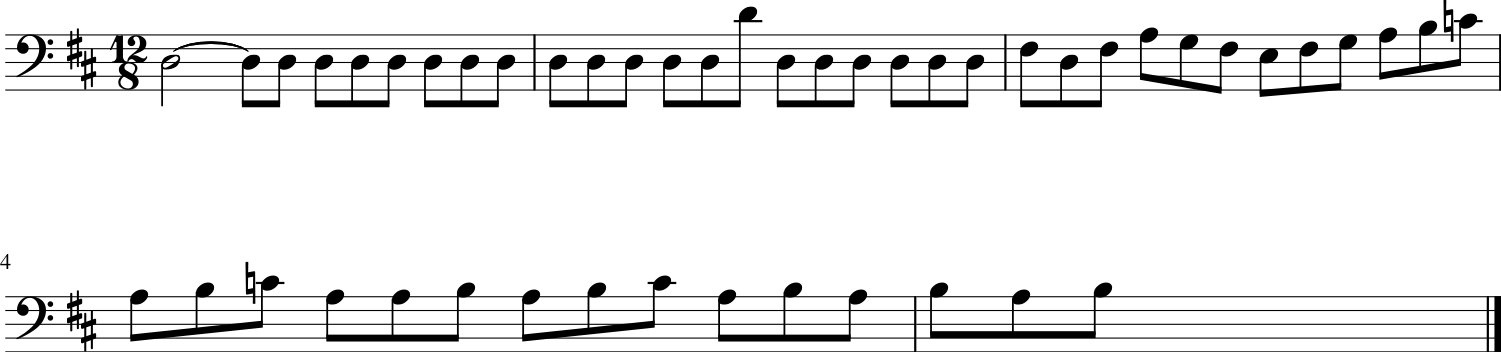

108/108 [==============================] - 13s 120ms/step - loss: 2.3872 - note_outputs_loss: 1.8402 - duration_outputs_loss: 0.5471
Epoch 75/5000
108/108 [==============================] - ETA: 0s - loss: 2.3789 - note_outputs_loss: 1.8317 - duration_outputs_loss: 0.5472[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'E-3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'E-4'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


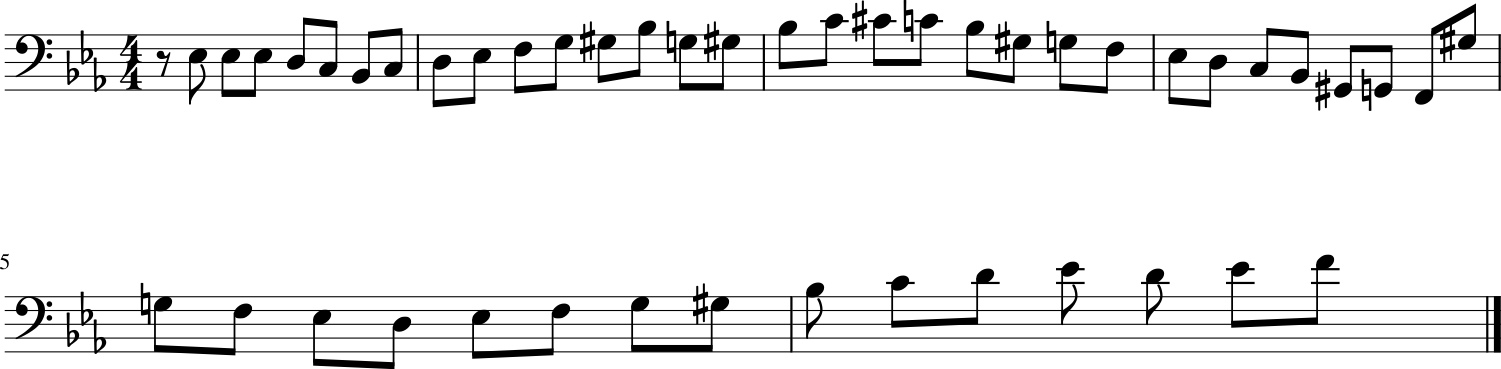

108/108 [==============================] - 13s 119ms/step - loss: 2.3789 - note_outputs_loss: 1.8317 - duration_outputs_loss: 0.5472
Epoch 76/5000
108/108 [==============================] - ETA: 0s - loss: 2.3659 - note_outputs_loss: 1.8220 - duration_outputs_loss: 0.5439[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'A3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'F#3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F2', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


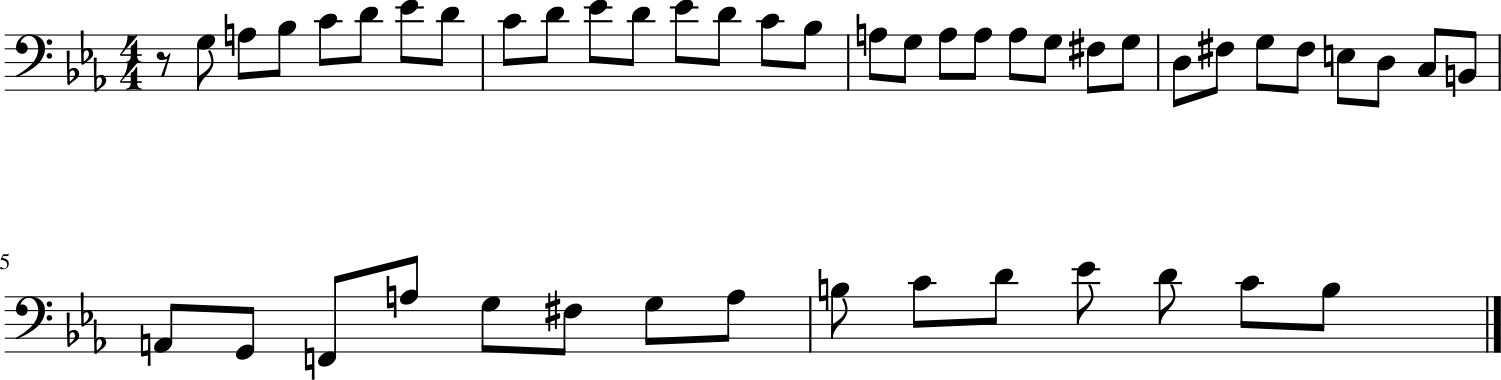

108/108 [==============================] - 13s 123ms/step - loss: 2.3659 - note_outputs_loss: 1.8220 - duration_outputs_loss: 0.5439
Epoch 77/5000
108/108 [==============================] - ETA: 0s - loss: 2.3673 - note_outputs_loss: 1.8220 - duration_outputs_loss: 0.5453[['START', 'E-:major', '3/4TS', 'rest', 'E-3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'E-3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'F3'], ['0.0', '0.0', '0.0', '2.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


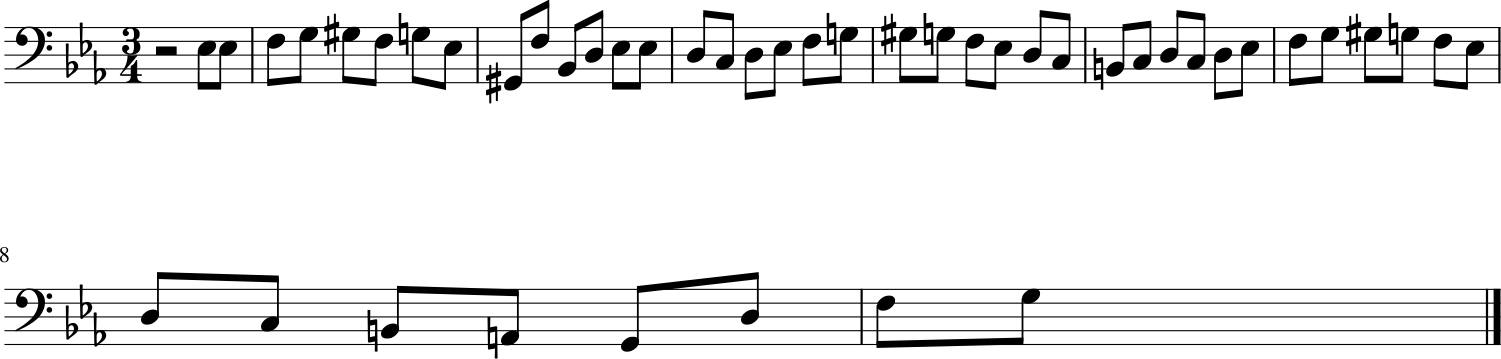

108/108 [==============================] - 13s 119ms/step - loss: 2.3673 - note_outputs_loss: 1.8220 - duration_outputs_loss: 0.5453
Epoch 78/5000
108/108 [==============================] - ETA: 0s - loss: 2.3646 - note_outputs_loss: 1.8150 - duration_outputs_loss: 0.5495[['START', 'G:major', '3/4TS', 'D3', 'D4', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


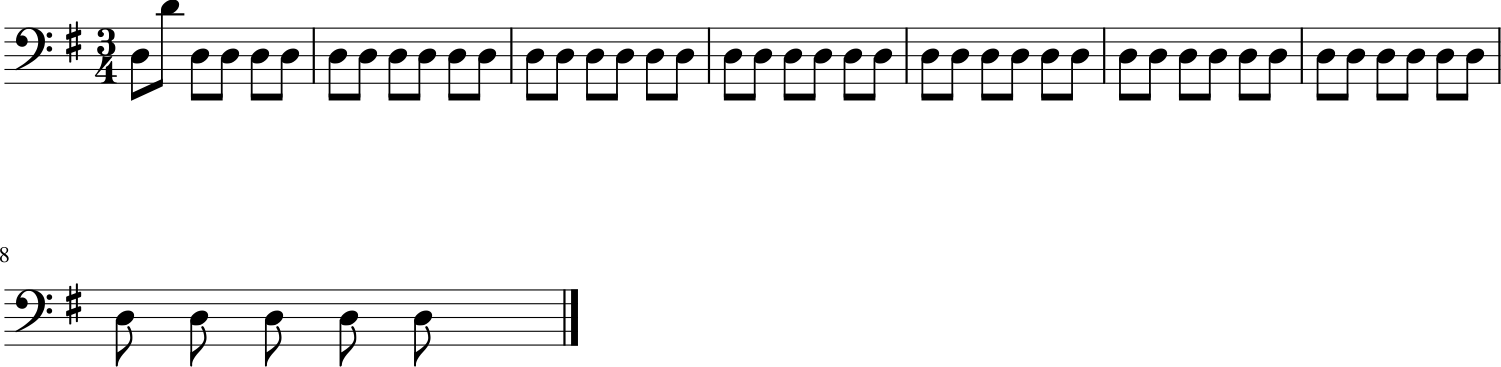

108/108 [==============================] - 14s 128ms/step - loss: 2.3646 - note_outputs_loss: 1.8150 - duration_outputs_loss: 0.5495
Epoch 79/5000
108/108 [==============================] - ETA: 0s - loss: 2.3546 - note_outputs_loss: 1.8054 - duration_outputs_loss: 0.5492[['START', 'D:major', '12/8TS', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'E3', 'F#3', 'D3', 'E3', 'F#3', 'D3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


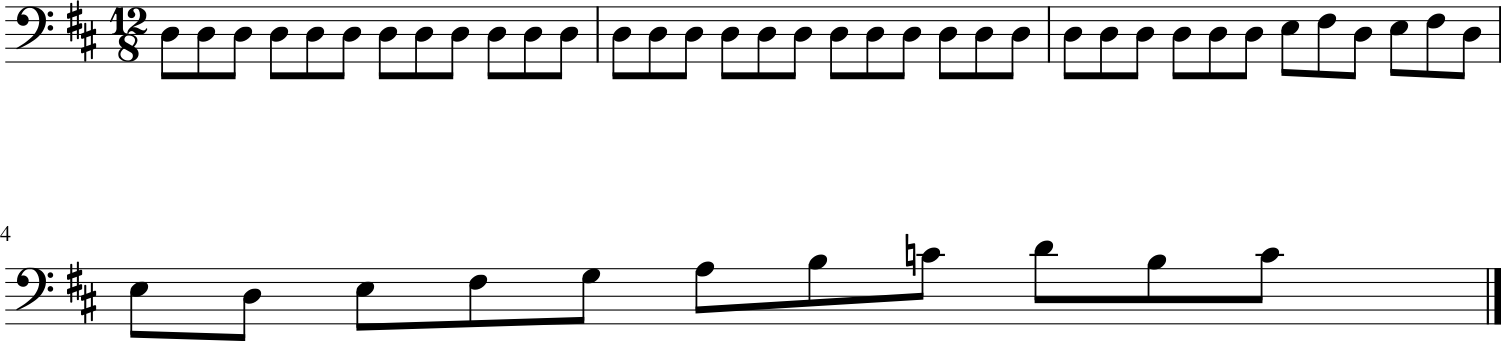

108/108 [==============================] - 13s 121ms/step - loss: 2.3546 - note_outputs_loss: 1.8054 - duration_outputs_loss: 0.5492
Epoch 80/5000
108/108 [==============================] - ETA: 0s - loss: 2.3449 - note_outputs_loss: 1.7993 - duration_outputs_loss: 0.5456[['START', 'D:major', '4/4TS', 'B4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'G#3', 'F#3', 'G#3', 'A3', 'B3', 'C#4', 'D4', 'E4', 'C#4', 'A3', 'E4', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'E4', 'C#4', 'E4', 'C#4', 'E4', 'B3', 'C#4', 'D4', 'E4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'F#4', 'E4', 'F#4', 'G4', 'E4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


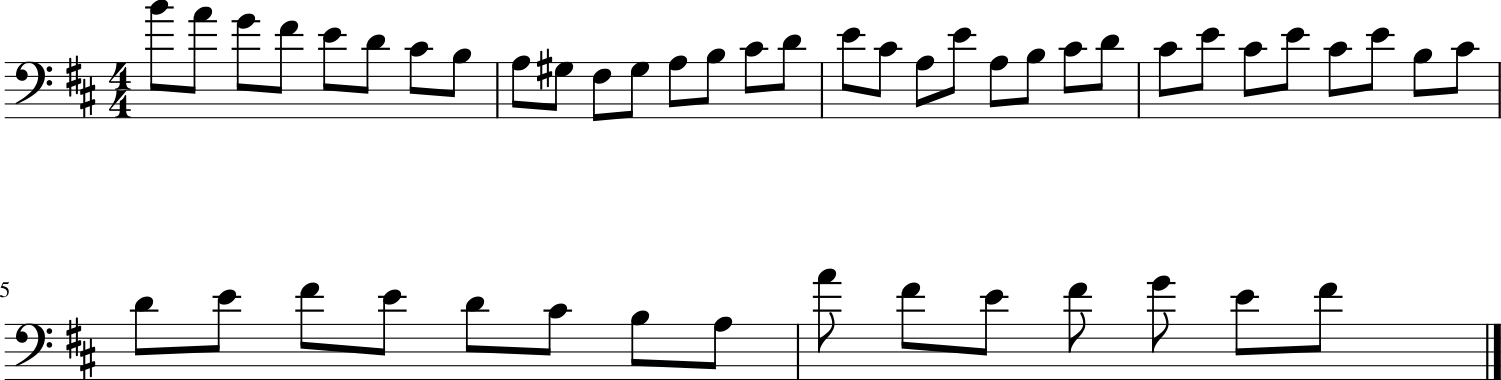

108/108 [==============================] - 16s 145ms/step - loss: 2.3449 - note_outputs_loss: 1.7993 - duration_outputs_loss: 0.5456
Epoch 81/5000
108/108 [==============================] - ETA: 0s - loss: 2.3443 - note_outputs_loss: 1.7992 - duration_outputs_loss: 0.5451[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'G3', 'C4', 'B-3', 'E-4', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'G2', 'F2', 'G2', 'E-2', 'F2', 'G2', 'G#2', 'F2', 'E-2', 'F2'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


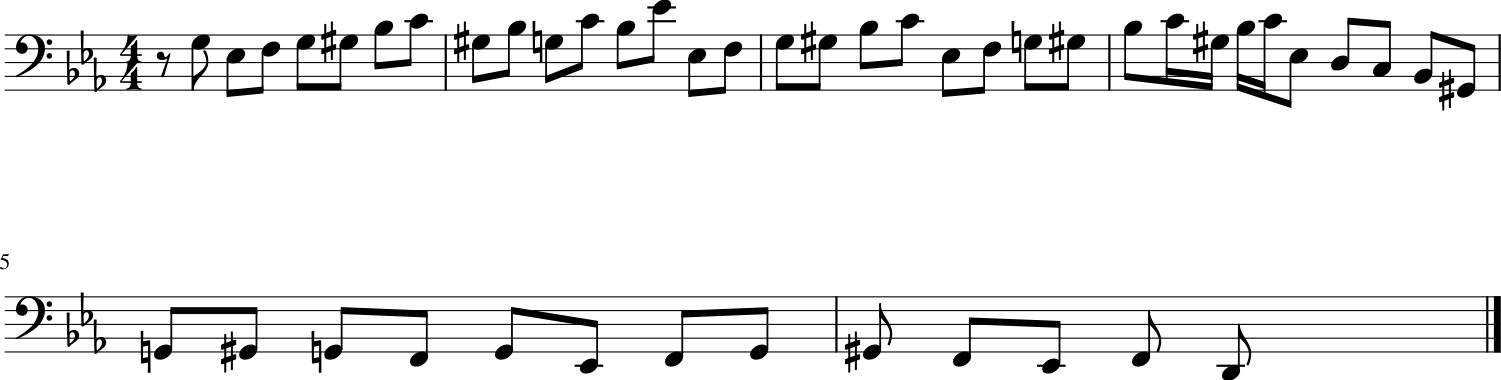

108/108 [==============================] - 13s 119ms/step - loss: 2.3443 - note_outputs_loss: 1.7992 - duration_outputs_loss: 0.5451
Epoch 82/5000
108/108 [==============================] - ETA: 0s - loss: 2.3245 - note_outputs_loss: 1.7828 - duration_outputs_loss: 0.5417[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'G#3', 'E-3', 'G#3', 'C3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'E-4', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


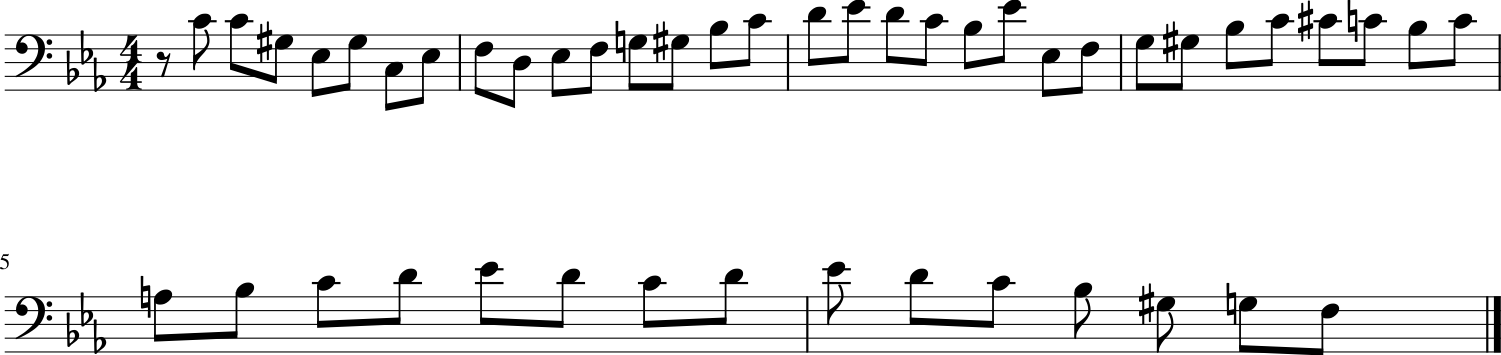

108/108 [==============================] - 13s 119ms/step - loss: 2.3245 - note_outputs_loss: 1.7828 - duration_outputs_loss: 0.5417
Epoch 83/5000
108/108 [==============================] - ETA: 0s - loss: 2.3174 - note_outputs_loss: 1.7739 - duration_outputs_loss: 0.5435[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'G#3', 'E-3', 'G#3', 'C3', 'E-3', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'D3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3'], ['0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


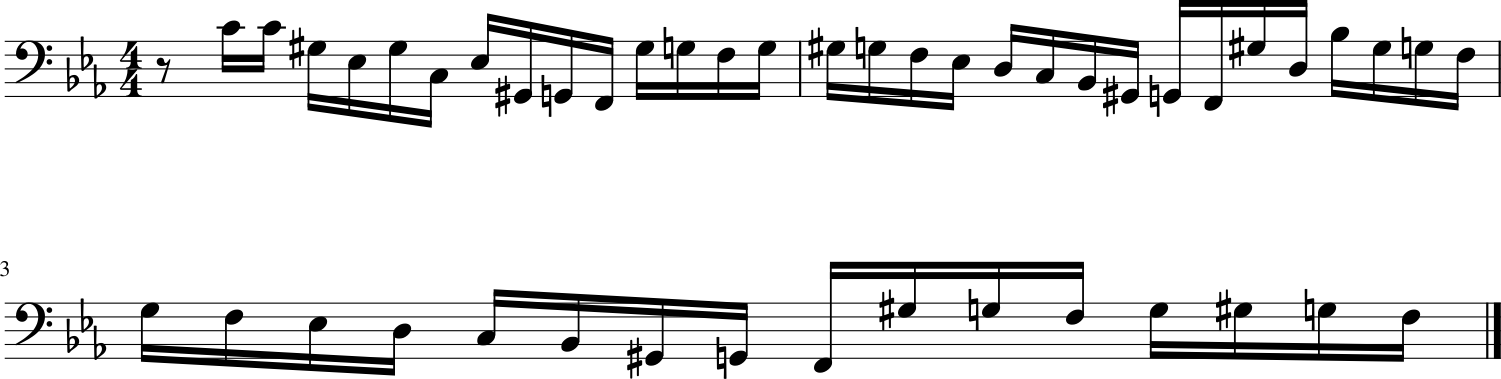

108/108 [==============================] - 13s 119ms/step - loss: 2.3174 - note_outputs_loss: 1.7739 - duration_outputs_loss: 0.5435
Epoch 84/5000
108/108 [==============================] - ETA: 0s - loss: 2.3187 - note_outputs_loss: 1.7774 - duration_outputs_loss: 0.5413[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'B-2', 'C3', 'D3', 'E-3', 'F3'], ['0.0', '0.5', '0.5', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


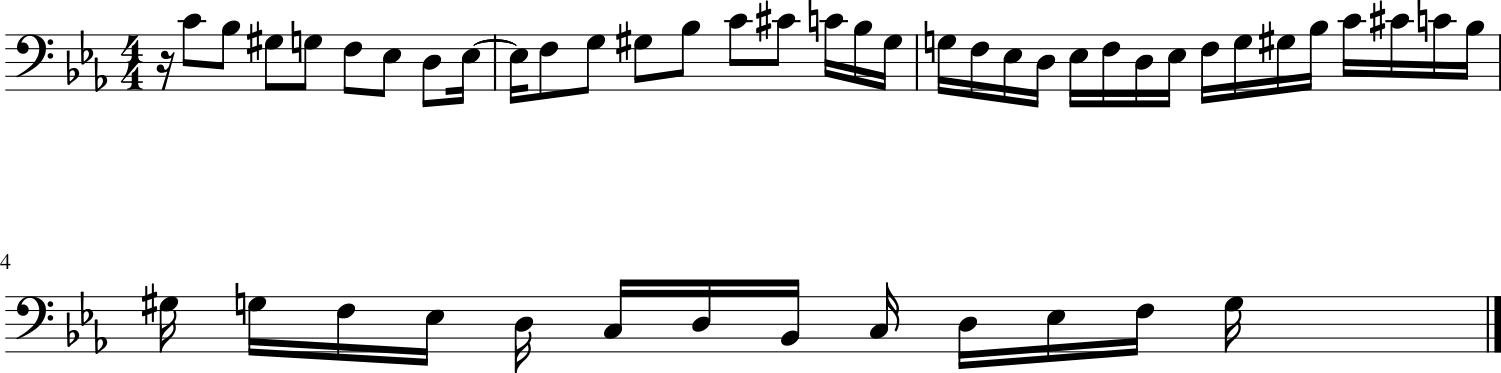

108/108 [==============================] - 13s 118ms/step - loss: 2.3187 - note_outputs_loss: 1.7774 - duration_outputs_loss: 0.5413
Epoch 85/5000
108/108 [==============================] - ETA: 0s - loss: 2.3160 - note_outputs_loss: 1.7671 - duration_outputs_loss: 0.5489[['START', 'F:major', '3/4TS', 'B-3', 'A3', 'B-3', 'C4', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


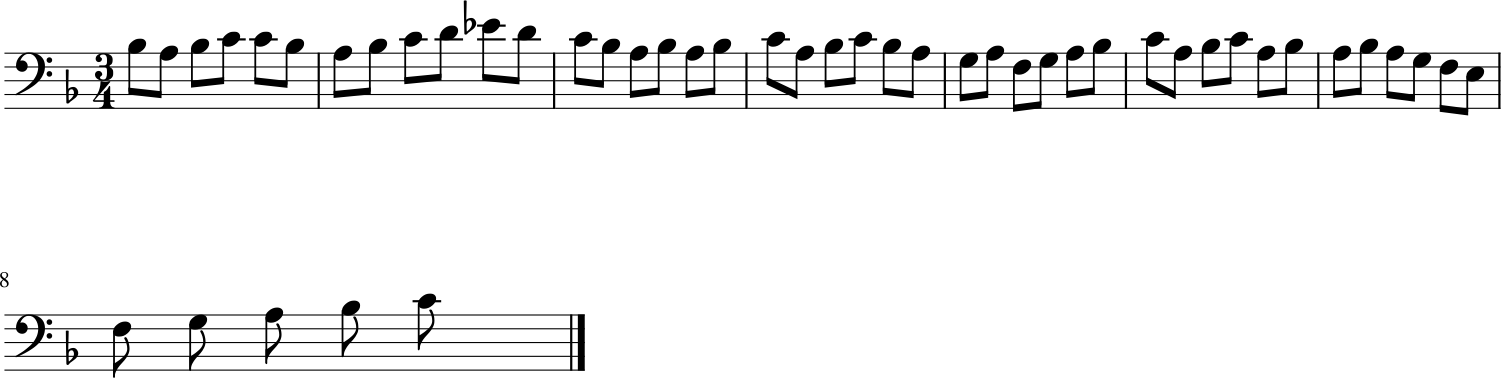

108/108 [==============================] - 13s 125ms/step - loss: 2.3160 - note_outputs_loss: 1.7671 - duration_outputs_loss: 0.5489
Epoch 86/5000
108/108 [==============================] - ETA: 0s - loss: 2.2999 - note_outputs_loss: 1.7585 - duration_outputs_loss: 0.5414[['START', 'E-:major', '4/4TS', 'rest', 'E-4', 'D4', 'B-3', 'B-3', 'A3', 'B-3', 'F3', 'B-2', 'B-2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'D3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'E-3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


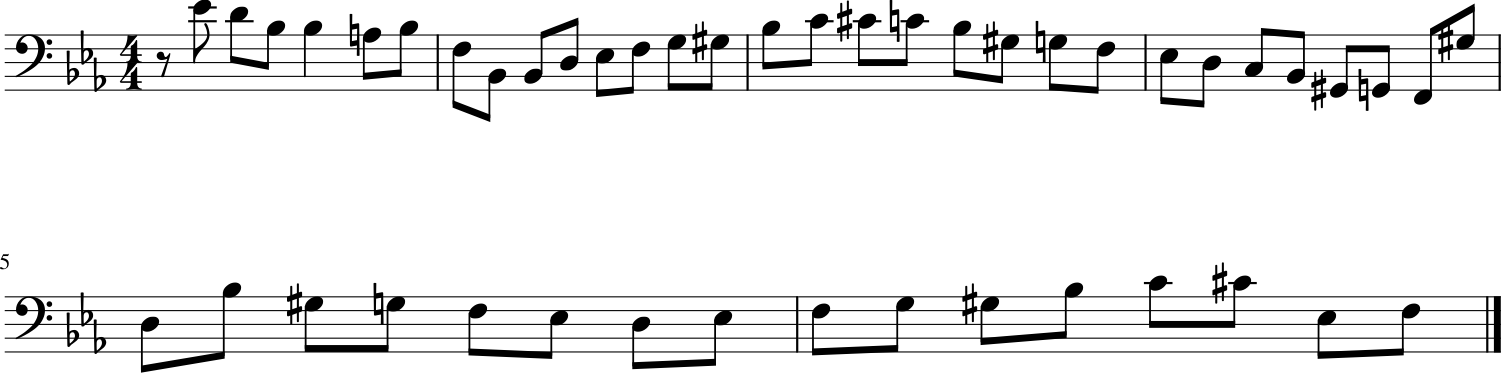

108/108 [==============================] - 13s 119ms/step - loss: 2.2999 - note_outputs_loss: 1.7585 - duration_outputs_loss: 0.5414
Epoch 87/5000
108/108 [==============================] - ETA: 0s - loss: 2.2899 - note_outputs_loss: 1.7441 - duration_outputs_loss: 0.5458[['START', 'D:major', '12/8TS', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


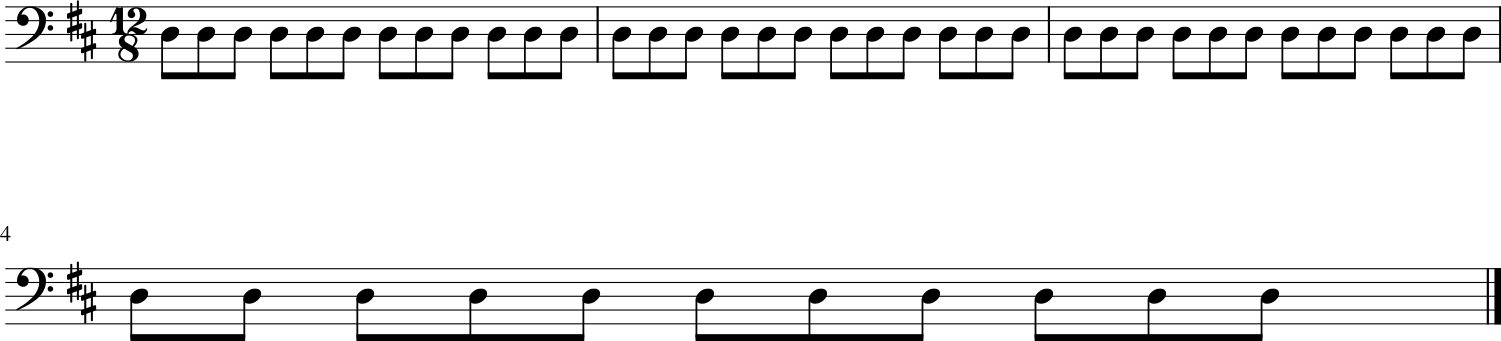

108/108 [==============================] - 13s 119ms/step - loss: 2.2899 - note_outputs_loss: 1.7441 - duration_outputs_loss: 0.5458
Epoch 88/5000
 96/108 [=========================>....] - ETA: 0s - loss: 2.2849 - note_outputs_loss: 1.7374 - duration_outputs_loss: 0.5475

In [ ]:
model.fit(
    ds,
    epochs=EPOCHS, 
    # initial_epoch = 150,
    callbacks = [model_checkpoint_callback, tensorboard_callback, music_generator]
)

In [ ]:
# Save the final model
model.save("./models/model")

# 3. Generate music using the Transformer

In [ ]:
def print_probs(info, notes_vocab, top_k = 5):
    for i in info:
        highlighted_text = []
        for note, duration, att_score in zip(i['prompt'][0], i['prompt'][1], np.mean(i['atts'], axis = 0)):
            highlighted_text.append('<span style="background-color:rgba(135,206,250,' + str(att_score / max(np.mean(i['atts'], axis = 0)) ) + ');">(' + note + ',' + duration + ')</span>')
        highlighted_text = ' '.join(highlighted_text)
        display(HTML(highlighted_text))
        
        note_probs = i['note_probs']
        p_sorted = np.sort(note_probs)[::-1][:top_k]
        i_sorted = np.argsort(note_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f'{notes_vocab[i]}:   \t{np.round(100*p,2)}%') 
        print('--------\n')

In [ ]:
info = music_generator.generate(
    ["START"]
    , ["0.0"]
    , max_tokens = 100
    , temperature = 0.5
)


In [ ]:
print_probs(info, notes_vocab)

In [189]:
midi_stream = info[-1]['midi'].chordify()
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write("midi", fp=os.path.join('/app/notebooks/music/bach-cello/output', "output-" + timestr + ".mid"))

'/app/notebooks/music/bach-cello/output/output-20221103-152703.mid'